In [1]:
# 2 AE + 1 AE -> 1 DECODER

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torchvision.utils import make_grid
from torch.optim import Adam
import json
from torchsummary import summary

from autoencoder.autoencoder import *
from PARCv1.differentiator import *
from PARCtorch.integrator.rk4 import *
from PARCtorch.integrator.numintegrator import *
from LatentPARC_model import *

# Set Seed

In [2]:
def set_seed(seed: int):
    # Set the seed for Python's built-in random module
    random.seed(seed)
    
    # Set the seed for NumPy
    np.random.seed(seed)
    
    # Set the seed for PyTorch (CPU)
    torch.manual_seed(seed)
    
    # Set the seed for PyTorch (GPU), if CUDA is available
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU.
    
    # Ensure deterministic behavior in certain cases
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # This can be set to True for non-deterministic algorithms (faster on some hardware)


set_seed(42)

# Load in data and normalize

In [3]:
# get PARCtorch path
path = os.path.abspath(os.path.join(os.getcwd(), "..")) 
print(path)

/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch


In [4]:
# Add the root directory (PARCTorch) to the system path
sys.path.append(path)
from data.normalization import compute_min_max

In [5]:
# Get single void HMX data
data_dirs = [
    "/project/vil_baek/data/physics/PARCTorch/HMX/train",
    "/project/vil_baek/data/physics/PARCTorch/HMX/test",
]
output_file = path + "/data/hmx_min_max.json"
compute_min_max(data_dirs, output_file)

Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC
Total files to process: 134
Processed 100/134 files.
Processed 134/134 files.
Channel-wise min values: [300.0, -1186907500.0, 0.0, -1995.0012, -5521.5503]
Channel-wise max values: [5000.0, 69721220000.0, 1.0, 7184.0073, 5215.695]
Min and max values saved to '/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/data/hmx_min_max.json'.


# Create Data Loaders

In [6]:
from torch.utils.data import DataLoader, random_split
import logging
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

# Example configuration for HMX dataset
data_dir_train = "/project/vil_baek/data/physics/PARCTorch/HMX/train"  # Replace with your actual train directory path
data_dir_test = "/project/vil_baek/data/physics/PARCTorch/HMX/test"  # Replace with your actual test directory path
future_steps = 1
# Path to the min_max.json file
min_max_path = os.path.join(path, "data", "hmx_min_max.json")  # Correct path
batch_size = 32
validation_split = 0.2  # 20% for validation

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Calculate the size of the validation set
validation_size = int(len(train_dataset) * validation_split)
train_size = len(train_dataset) - validation_size

# Perform the split
train_subset, val_subset = random_split(train_dataset, [train_size, validation_size])

# Create DataLoader for training and validation datasets
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the training data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

# Optionally, create DataLoader for test dataset
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,  # No need to shuffle test data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2025-04-06 20:24:52,537 [INFO] Starting data validation...
2025-04-06 20:24:52,539 [INFO] Validating .npy files...
Validating files: 100%|██████████| 100/100 [00:00<00:00, 311.19it/s]
2025-04-06 20:24:52,867 [INFO] Data validation completed successfully.
2025-04-06 20:24:52,869 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 100/100 [00:00<00:00, 293.17it/s]
2025-04-06 20:24:53,215 [INFO] Total samples in dataset: 1400
2025-04-06 20:24:53,220 [INFO] Starting data validation...
2025-04-06 20:24:53,222 [INFO] Validating .npy files...
Validating files: 100%|██████████| 34/34 [00:00<00:00, 299.26it/s]
2025-04-06 20:24:53,341 [INFO] Data validation completed successfully.
2025-04-06 20:24:53,343 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 34/34 [00:00<00:00, 436.10it/s]
2025-04-06 20:24:53,426 [INFO] Total samples in dataset: 476


# Model Creation and Training

In [7]:
# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes_TP = [2, 4]
latent_dim_TP = 8
layer_sizes_M = [1, 2]
latent_dim_M = 4

layer_sizes_decoder = [3, 8]
latent_dim = latent_dim_TP + latent_dim_M # 12

encoder_TP = Encoder(layers=layer_sizes_TP, latent_dim=latent_dim_TP).to(device)
encoder_M = Encoder(layers=layer_sizes_M, latent_dim=latent_dim_M).to(device)
decoder = Decoder(layers=layer_sizes_decoder, latent_dim=latent_dim).to(device)
differentiator = Differentiator(latent_dim=latent_dim)
integrator = RK4().to(device)  # step size may be hyper-param of interest

# Initialize LatentPARC
model_init = lp_model_2plus1_1decoder(encoder_TP, encoder_M, decoder, differentiator, integrator).to(device)

#Loss Function
criterion = torch.nn.L1Loss().to(device)
# criterion = nn.MSELoss()
# criterion = LpLoss(p=10).cuda()

# #### BEGIN PERCEPTUAL LOSS BLOCK
# # Initialize Perceptual Loss
# feature_extractor = FeatureExtractor().to(device)
# perceptual_loss = PerceptualLoss(feature_extractor).to(device)

# # Perceptual Loss + L1 Combined Criterion
# def combined_loss(output, target):
#     l1_loss = criterion(output, target)  # Existing L1 loss
#     # Check if the number of channels is 3 before computing perceptual loss
#     if target.shape[1] == 3:  
#         p_loss = perceptual_loss(output, target)  # Perceptual loss
#     else:
#         p_loss = 0  # No perceptual loss for latent space data (more than 3 channels)
#     total_loss = l1_loss + 0.1 * p_loss  # Weight perceptual loss (adjust 0.1 as needed)
#     return total_loss
# #### END PERCEPTUAL LOSS BLOCK

# Define Optimizer
optimizer = Adam(model_init.parameters(), lr=1e-3)

# Define learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [8]:
# where to save weights
save_path="/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC"
weights_name="test"

#  training model
model = LatentPARC(model_init, optimizer, save_path, weights_name)

log_dict = model.train(loss_function=criterion, epochs=50, image_size = [128, 256], n_channels=3, device=device, 
                       train_loader=train_loader, val_loader=val_loader, scheduler=scheduler,
                       noise_fn=add_random_noise, initial_max_noise=0.16, n_reduce_factor=0.5, 
                       ms_reduce_factor=0, reduce_on=3, loss_weights=[1.0,10.0,1.0])


Epoch 1/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.06it/s]


Epoch 1: Training Loss: 0.4814 | Validation Loss: 0.1732

Epoch 2/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.55it/s]


Epoch 2: Training Loss: 0.1395 | Validation Loss: 0.1104

Epoch 3/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  6.70it/s]


Epoch 3: Training Loss: 0.1117 | Validation Loss: 0.1124

Epoch 4/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.45it/s]


Epoch 4: Training Loss: 0.1101 | Validation Loss: 0.1160

Epoch 5/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.44it/s]


Epoch 5: Training Loss: 0.1107 | Validation Loss: 0.1070

Epoch 6/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.39it/s]


Epoch 6: Training Loss: 0.1066 | Validation Loss: 0.1048

Epoch 7/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  6.88it/s]


Epoch 7: Training Loss: 0.1053 | Validation Loss: 0.1037

Epoch 8/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]


Epoch 8: Training Loss: 0.1039 | Validation Loss: 0.1007

Epoch 9/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s]


Epoch 9: Training Loss: 0.1078 | Validation Loss: 0.1130

Epoch 10/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.58it/s]


Epoch 10: Training Loss: 0.1054 | Validation Loss: 0.1044

Epoch 11/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.38it/s]


Epoch 11: Training Loss: 0.0995 | Validation Loss: 0.0960

Epoch 12/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.54it/s]


Epoch 12: Training Loss: 0.0962 | Validation Loss: 0.0927

Epoch 13/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.56it/s]


Epoch 13: Training Loss: 0.0964 | Validation Loss: 0.0984

Epoch 14/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.51it/s]


Epoch 14: Training Loss: 0.0947 | Validation Loss: 0.0973

Epoch 15/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  6.77it/s]


Epoch 15: Training Loss: 0.0931 | Validation Loss: 0.1015

Epoch 16/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  6.97it/s]


Epoch 16: Training Loss: 0.0924 | Validation Loss: 0.0918

Epoch 17/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.58it/s]


Epoch 17: Training Loss: 0.0886 | Validation Loss: 0.0947

Epoch 18/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.61it/s]


Epoch 18: Training Loss: 0.0912 | Validation Loss: 0.0936

Epoch 19/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.45it/s]


Epoch 19: Training Loss: 0.0888 | Validation Loss: 0.0864

Epoch 20/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.38it/s]


Epoch 20: Training Loss: 0.0877 | Validation Loss: 0.0871

Epoch 21/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s]


Epoch 21: Training Loss: 0.0877 | Validation Loss: 0.0968

Epoch 22/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  6.60it/s]


Epoch 22: Training Loss: 0.0859 | Validation Loss: 0.0887

Epoch 23/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  6.86it/s]


Epoch 23: Training Loss: 0.0859 | Validation Loss: 0.0877

Epoch 24/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.19it/s]


Epoch 24: Training Loss: 0.0881 | Validation Loss: 0.0848

Epoch 25/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.36it/s]


Epoch 25: Training Loss: 0.0871 | Validation Loss: 0.0892

Epoch 26/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.34it/s]


Epoch 26: Training Loss: 0.0866 | Validation Loss: 0.0886

Epoch 27/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.57it/s]


Epoch 27: Training Loss: 0.0861 | Validation Loss: 0.0867

Epoch 28/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.30it/s]


Epoch 28: Training Loss: 0.0847 | Validation Loss: 0.0858

Epoch 29/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  6.70it/s]


Epoch 29: Training Loss: 0.0844 | Validation Loss: 0.0870

Epoch 30/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s]


Epoch 30: Training Loss: 0.0836 | Validation Loss: 0.0819

Epoch 31/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.24it/s]


Epoch 31: Training Loss: 0.0788 | Validation Loss: 0.0763

Epoch 32/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.14it/s]


Epoch 32: Training Loss: 0.0753 | Validation Loss: 0.0771

Epoch 33/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.09it/s]


Epoch 33: Training Loss: 0.0759 | Validation Loss: 0.0727

Epoch 34/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.21it/s]


Epoch 34: Training Loss: 0.0762 | Validation Loss: 0.0734

Epoch 35/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  6.87it/s]


Epoch 35: Training Loss: 0.0766 | Validation Loss: 0.0722

Epoch 36/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s]


Epoch 36: Training Loss: 0.0745 | Validation Loss: 0.0760

Epoch 37/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.69it/s]


Epoch 37: Training Loss: 0.0749 | Validation Loss: 0.0732

Epoch 38/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s]


Epoch 38: Training Loss: 0.0760 | Validation Loss: 0.0775

Epoch 39/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.55it/s]


Epoch 39: Training Loss: 0.0750 | Validation Loss: 0.0768

Epoch 40/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.52it/s]


Epoch 40: Training Loss: 0.0773 | Validation Loss: 0.0800

Epoch 41/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.40it/s]


Epoch 41: Training Loss: 0.0757 | Validation Loss: 0.0747

Epoch 42/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  6.65it/s]


Epoch 42: Training Loss: 0.0753 | Validation Loss: 0.0826

Epoch 43/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.13it/s]


Epoch 43: Training Loss: 0.0775 | Validation Loss: 0.0725

Epoch 44/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  6.51it/s]


Epoch 44: Training Loss: 0.0741 | Validation Loss: 0.0780

Epoch 45/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.35it/s]


Epoch 45: Training Loss: 0.0734 | Validation Loss: 0.0727

Epoch 46/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s]


Epoch 46: Training Loss: 0.0731 | Validation Loss: 0.0766

Epoch 47/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.36it/s]


Epoch 47: Training Loss: 0.0735 | Validation Loss: 0.0730

Epoch 48/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]


Epoch 48: Training Loss: 0.0722 | Validation Loss: 0.0709

Epoch 49/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  6.51it/s]


Epoch 49: Training Loss: 0.0720 | Validation Loss: 0.0714

Epoch 50/50


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.38it/s]

Epoch 50: Training Loss: 0.0716 | Validation Loss: 0.0718
Model and logs saved to /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC


# Load Pretrained Weights

In [7]:
# define model
# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes_TP = [2, 4]
latent_dim_TP = 4
layer_sizes_M = [1, 2]
latent_dim_M = 2

layer_sizes_decoder = [3, 6]
latent_dim = latent_dim_TP + latent_dim_M # 12

encoder_TP = Encoder(layers=layer_sizes_TP, latent_dim=latent_dim_TP).to(device)
encoder_M = Encoder(layers=layer_sizes_M, latent_dim=latent_dim_M).to(device)
decoder = Decoder(layers=layer_sizes_decoder, latent_dim=latent_dim).to(device)
differentiator = Differentiator(latent_dim=latent_dim)
integrator = RK4().to(device)  # step size may be hyper-param of interest

# Initialize LatentPARC
model_init = lp_model_2plus1_1decoder(encoder_TP, encoder_M, decoder, differentiator, integrator).to(device)

#Loss Function
criterion = torch.nn.L1Loss().to(device)
# criterion = LpLoss(p=10).cuda()

# criterion = nn.MSELoss()
optimizer = Adam(model_init.parameters(), lr=1e-3)

#  training model
model = LatentPARC(model_init, optimizer)

In [8]:
# load weights into model
weights_path = "layers_2_4_latent_4_1_2_latent_2_decoder_3_6_LP_2plus1_1decoder_Nmax16_nrf8_redon500_LRstep_e3_factor8_stepsize200_nts1_3000.pth"

model.network.load_state_dict(torch.load(weights_path))
model.network.eval()  # Set to evaluation mode

/tmp/ipykernel_174026/3438911780.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.network.load_state_dict(torch.load(weights_path))


lp_model_2plus1_1decoder(
  (encoderTP): Encoder(
    (net): Sequential(
      (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (encoderM): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder): Decoder(
    (conv): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode='bilinear')
      (4): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
  (differentiator): Differentiator(
    (b1c1): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model.network)}")

Total trainable parameters: 1262191


# Make Predictions

### Single ts preds

In [10]:
n_channels = 3

just_AE_reconstruction_GT = []
just_AE_reconstruction_pred = []

single_ts_full_reconstruction_GT = []
single_ts_full_reconstruction_pred = []

single_ts_Zhat = []
# single_ts_Z_pred = []

for test_image in test_loader: #!!! test
    ic, _, _, target = test_image
    ic = ic[:, 0:n_channels, ...].to(device)
    target = target.squeeze(0)[:, 0:n_channels, ...].to(device)
    
    with torch.no_grad():
        # Reconstructing test images
        _, x_bar = model.network(ic, n_ts=0) #maybe for efficiency, save z here and feed into next line if just differentiator?? only need to encode once even if doing rollout
        z_hat, x_hat = model.network(ic, n_ts=1)
        # z_hat_next, _ = model.network(target, n_ts=0)
        
    # Sending reconstructed and original images to CPU and accumulating in lists
    just_AE_reconstruction_GT.append(ic.cpu())
    just_AE_reconstruction_pred.append(x_bar.cpu())
    
    single_ts_full_reconstruction_GT.append(target.cpu())
    single_ts_full_reconstruction_pred.append(x_hat.cpu())
    
    single_ts_Zhat.append(z_hat.cpu())

# Concatenate all batches to create single tensors
just_AE_reconstruction_GT = torch.cat(just_AE_reconstruction_GT, dim=0)  # Shape: (total_images, n_channels, height, width)
just_AE_reconstruction_pred = torch.cat(just_AE_reconstruction_pred, dim=0)

single_ts_full_reconstruction_GT = torch.cat(single_ts_full_reconstruction_GT, dim=0)  # Shape: (total_images, n_channels, height, width)
single_ts_full_reconstruction_pred = torch.cat(single_ts_full_reconstruction_pred, dim=0)

single_ts_Zhat = torch.cat(single_ts_Zhat, dim=0)  # Shape: (total_images, n_channels, height, width)

In [11]:
single_ts_full_reconstruction_GT.shape, single_ts_Zhat.shape

(torch.Size([476, 3, 128, 256]), torch.Size([476, 6, 32, 64]))

### Visualizations

#### AE Reconstruction

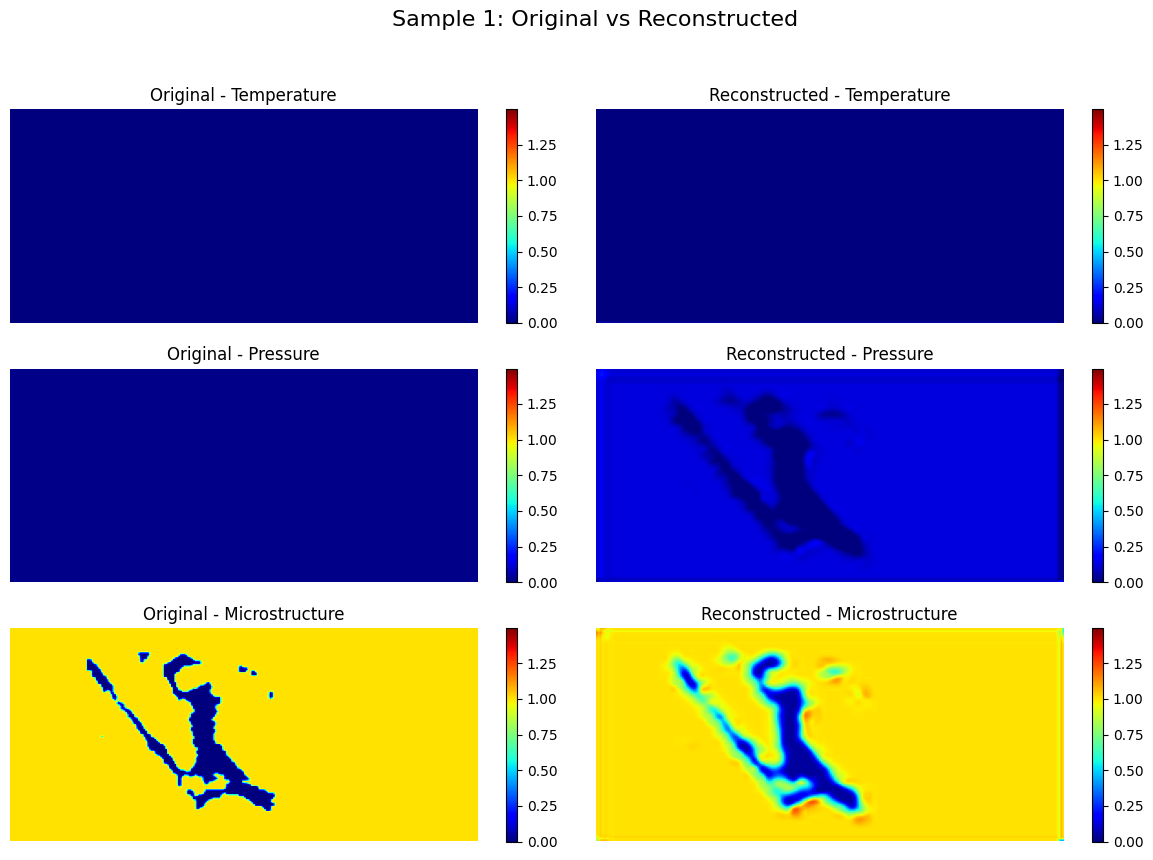

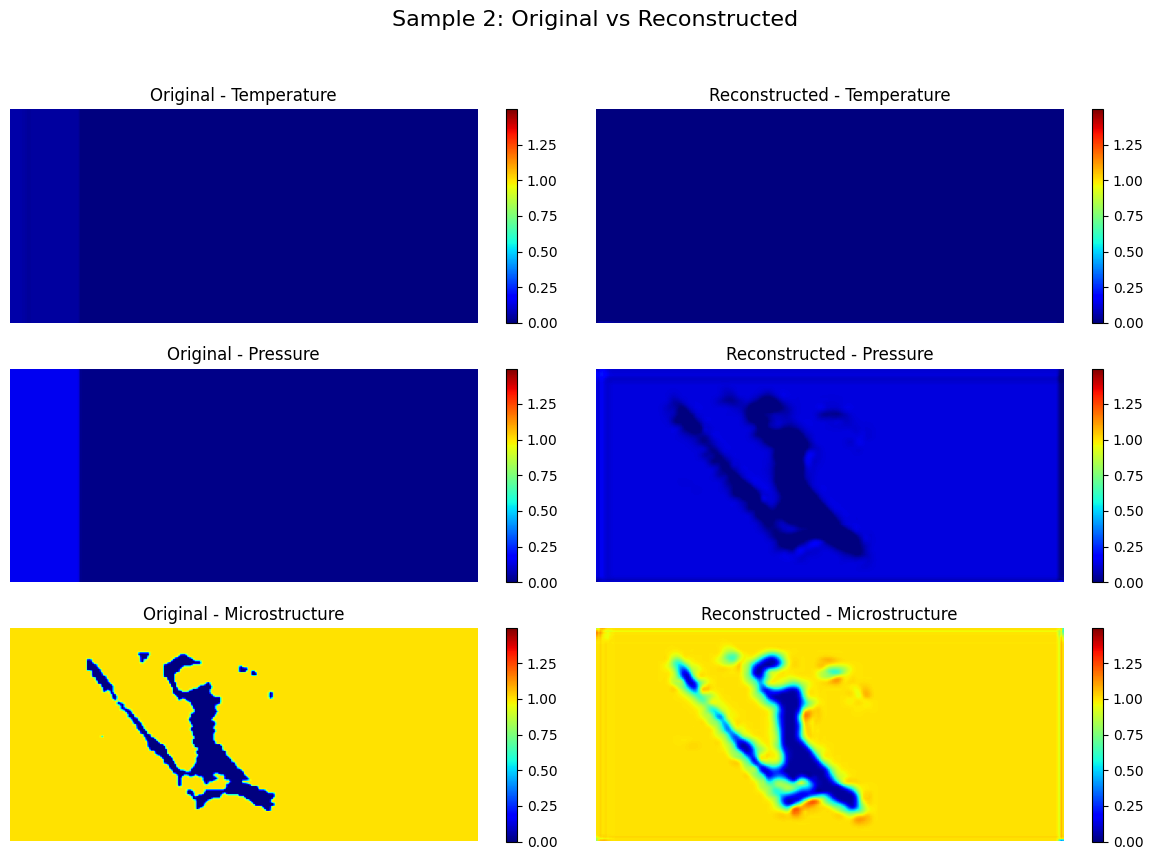

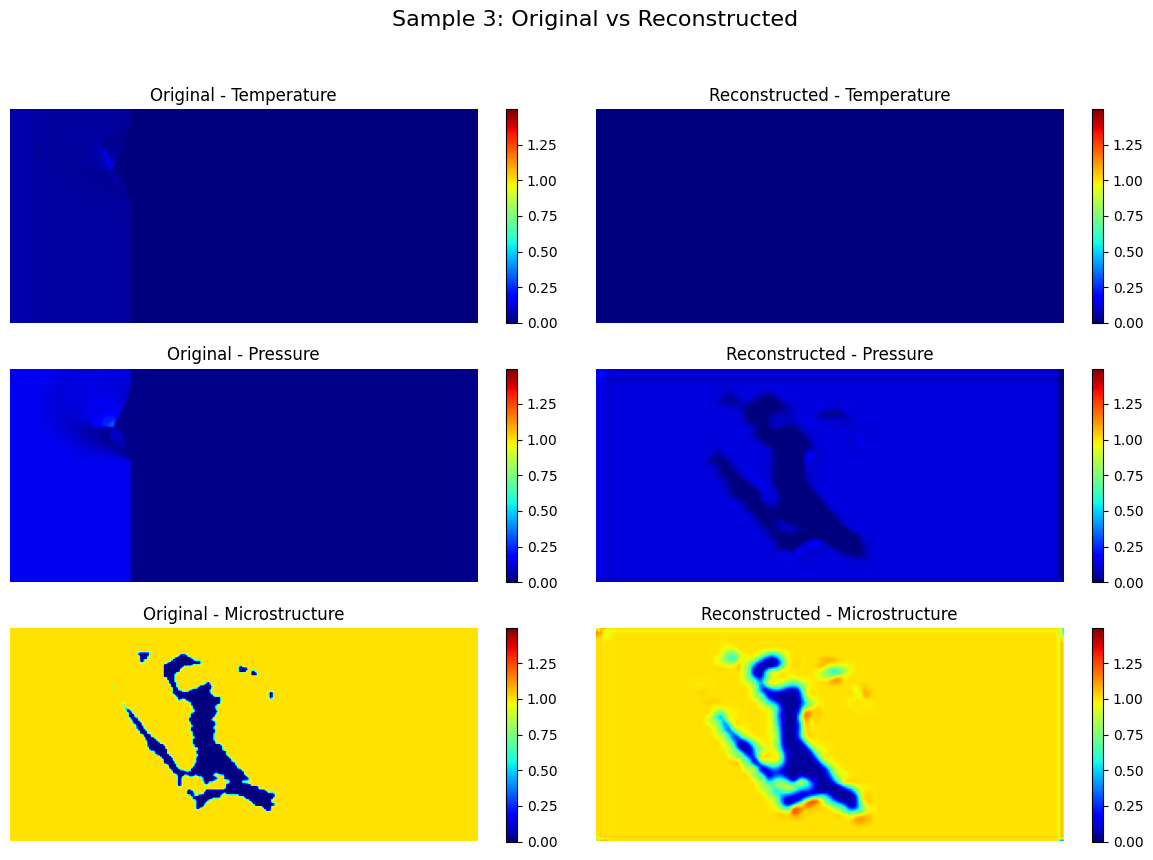

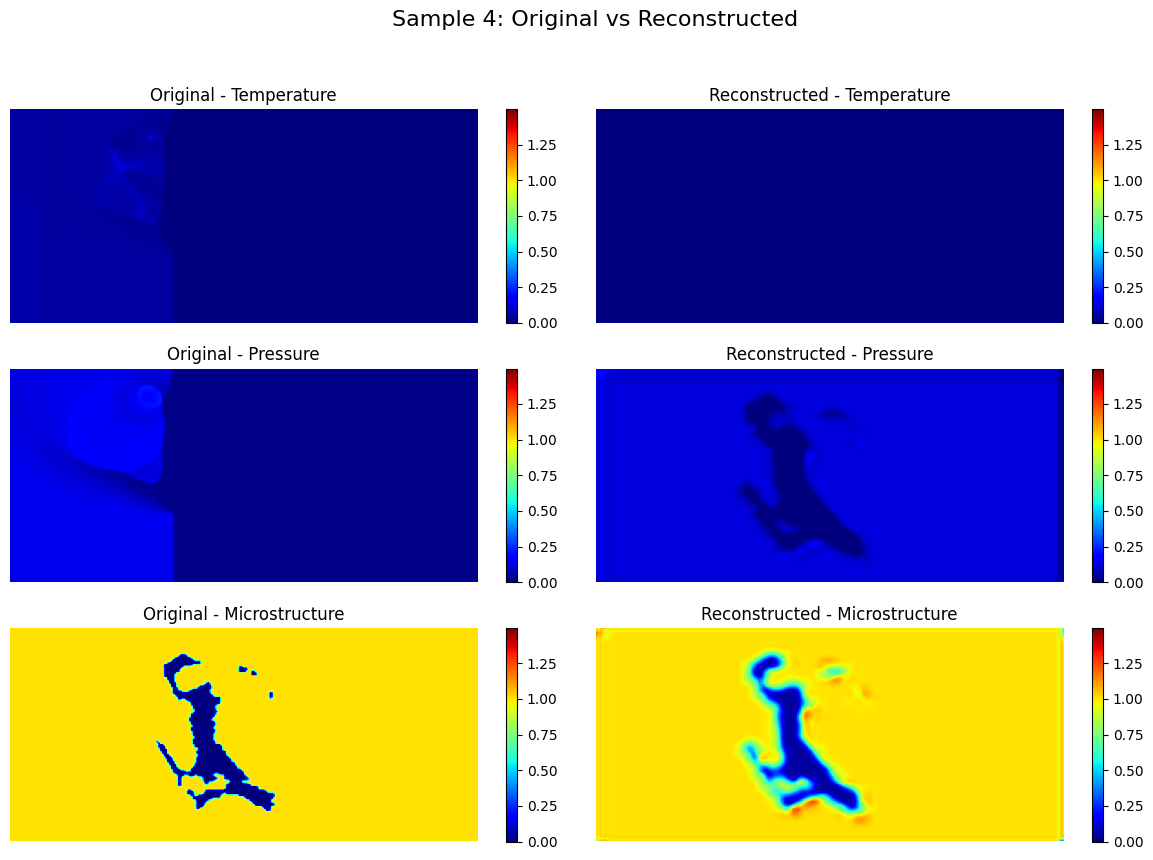

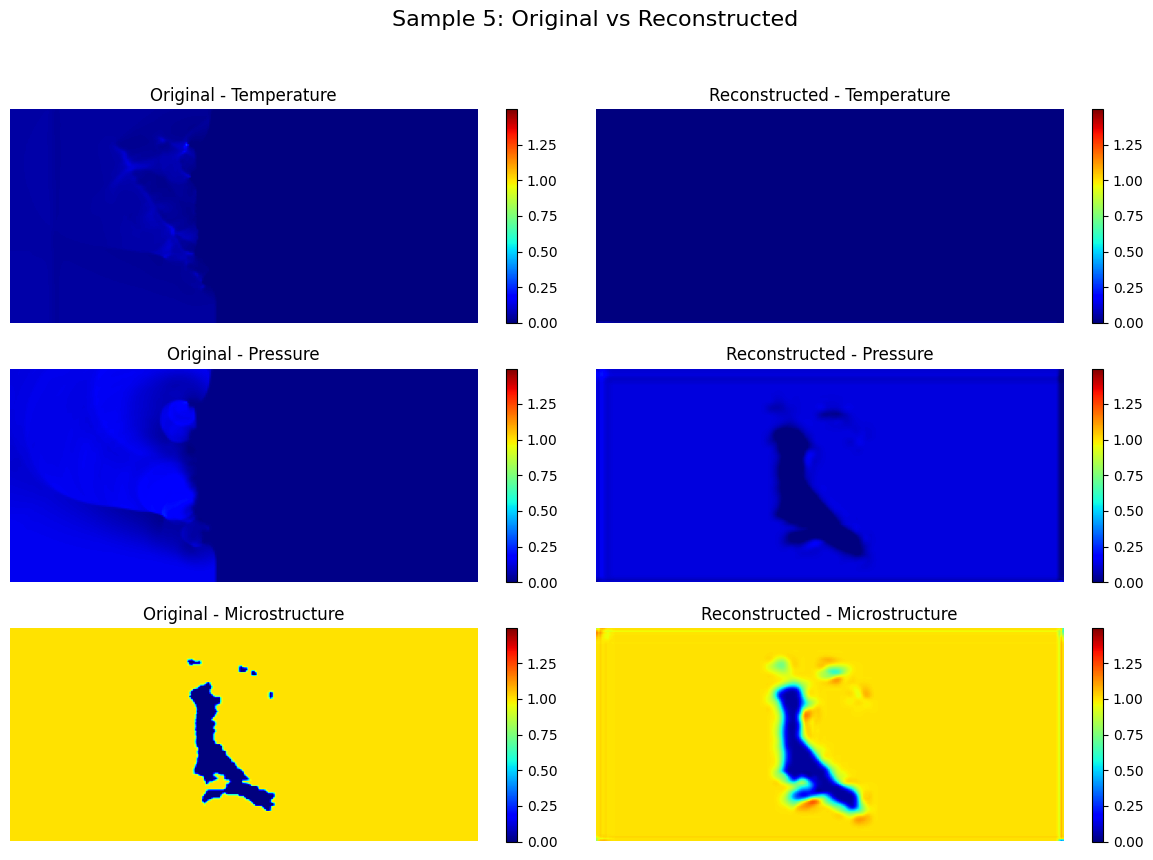

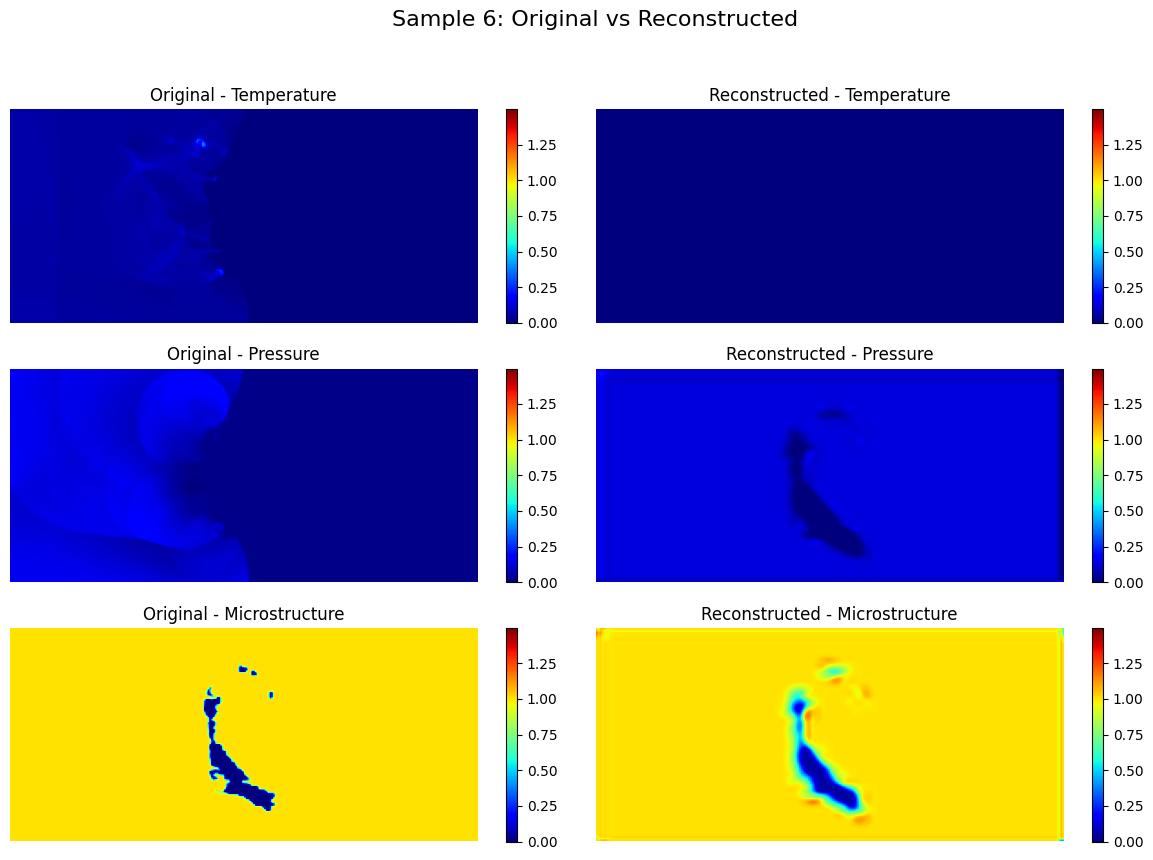

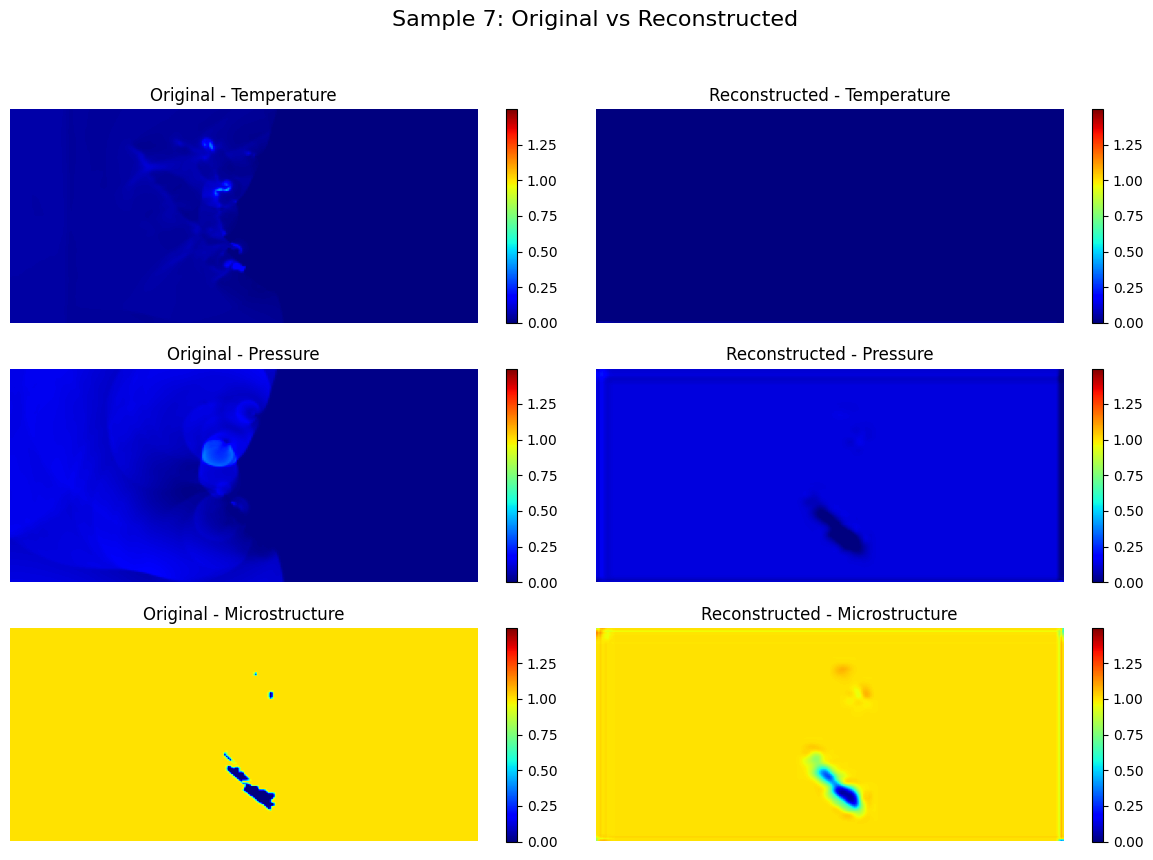

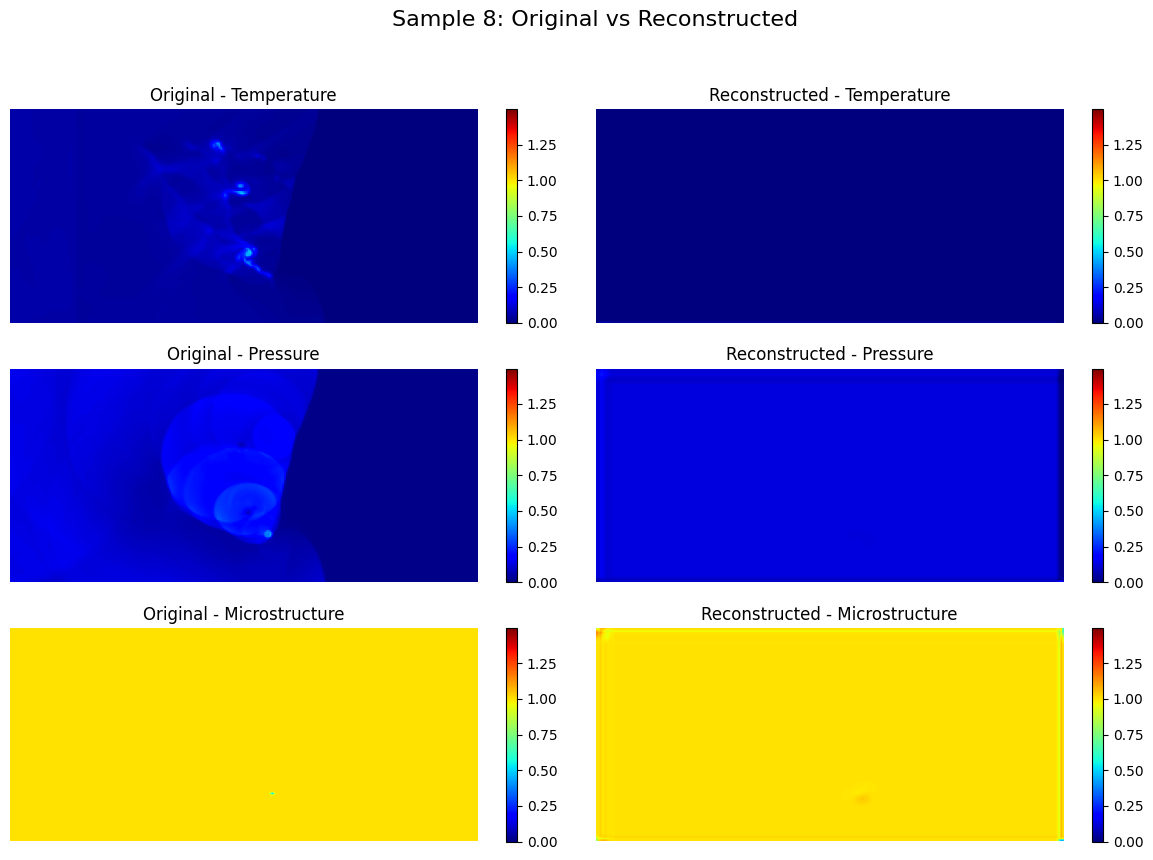

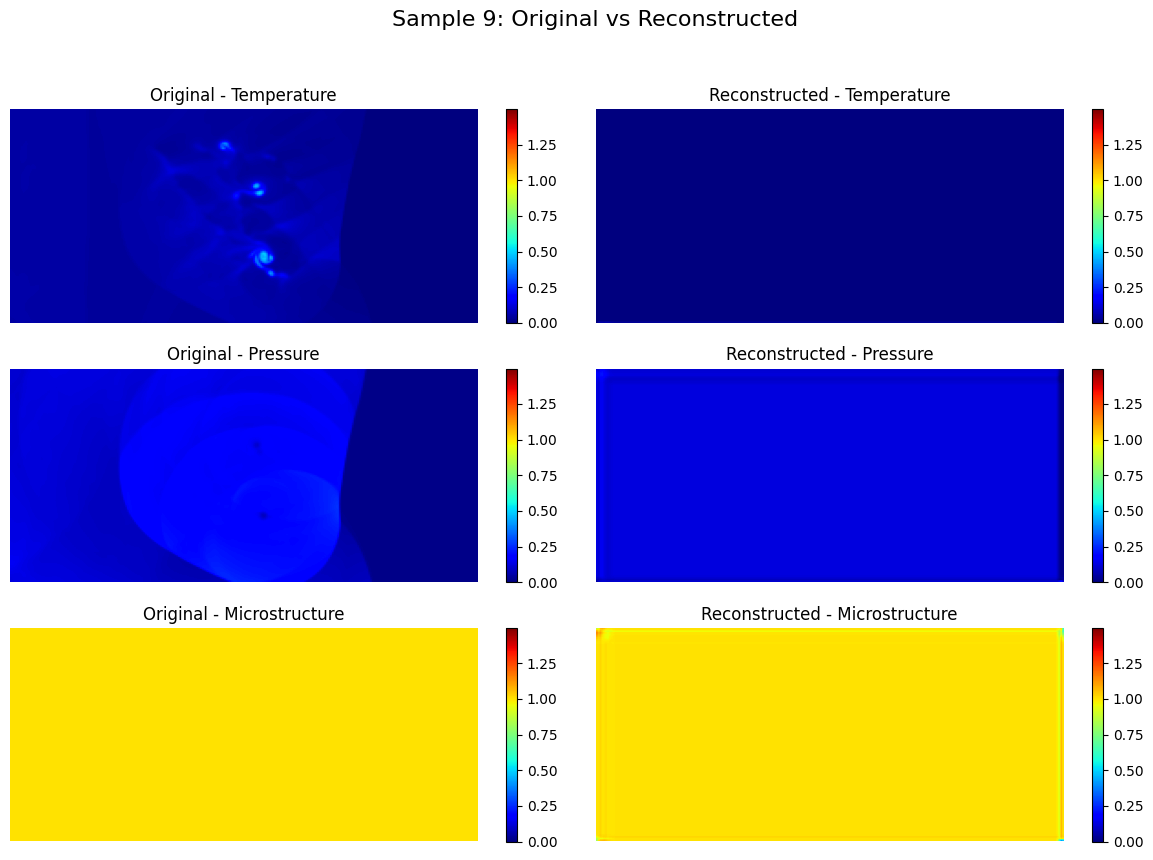

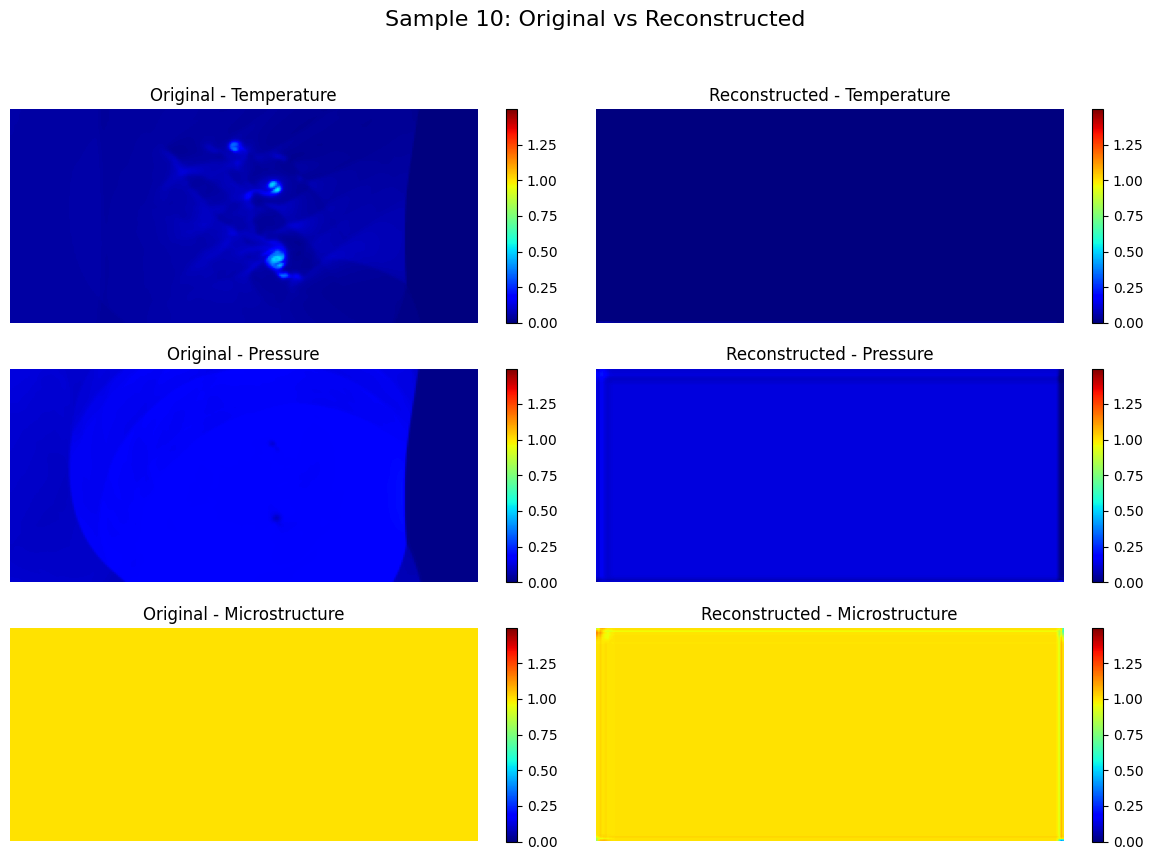

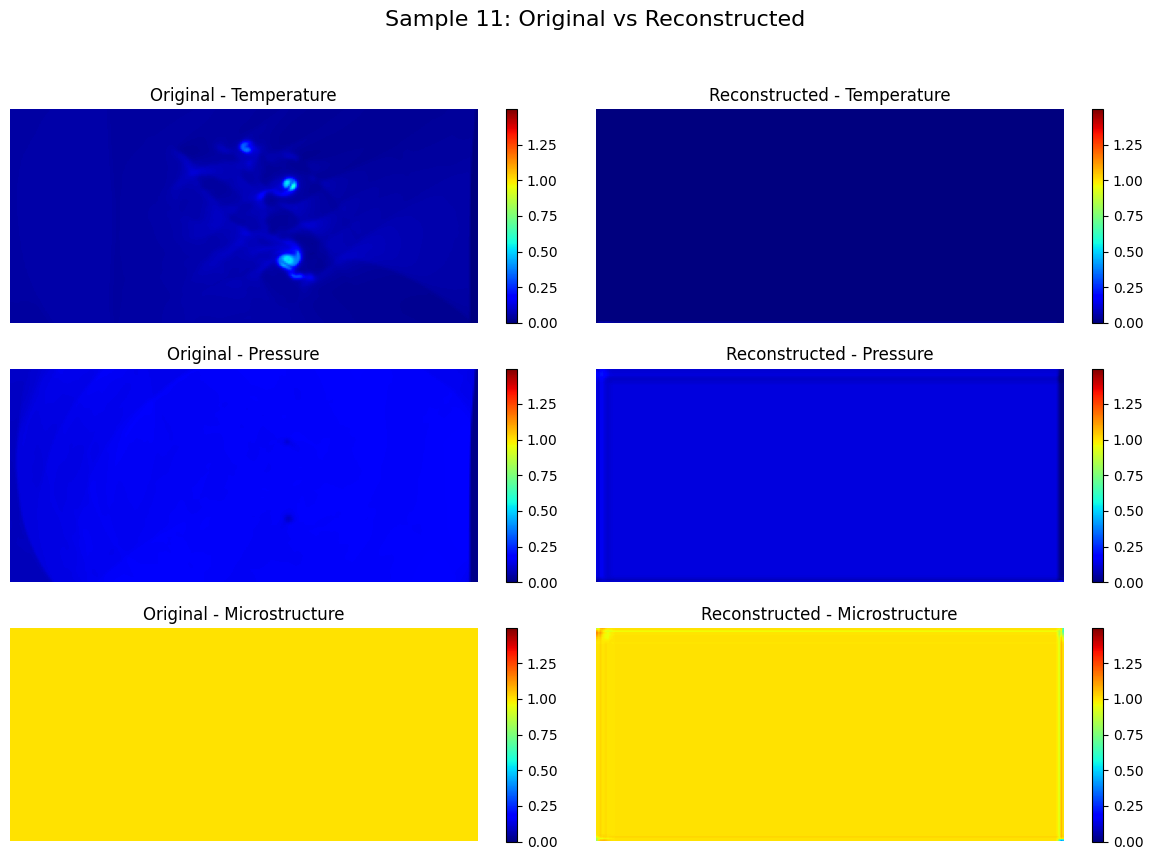

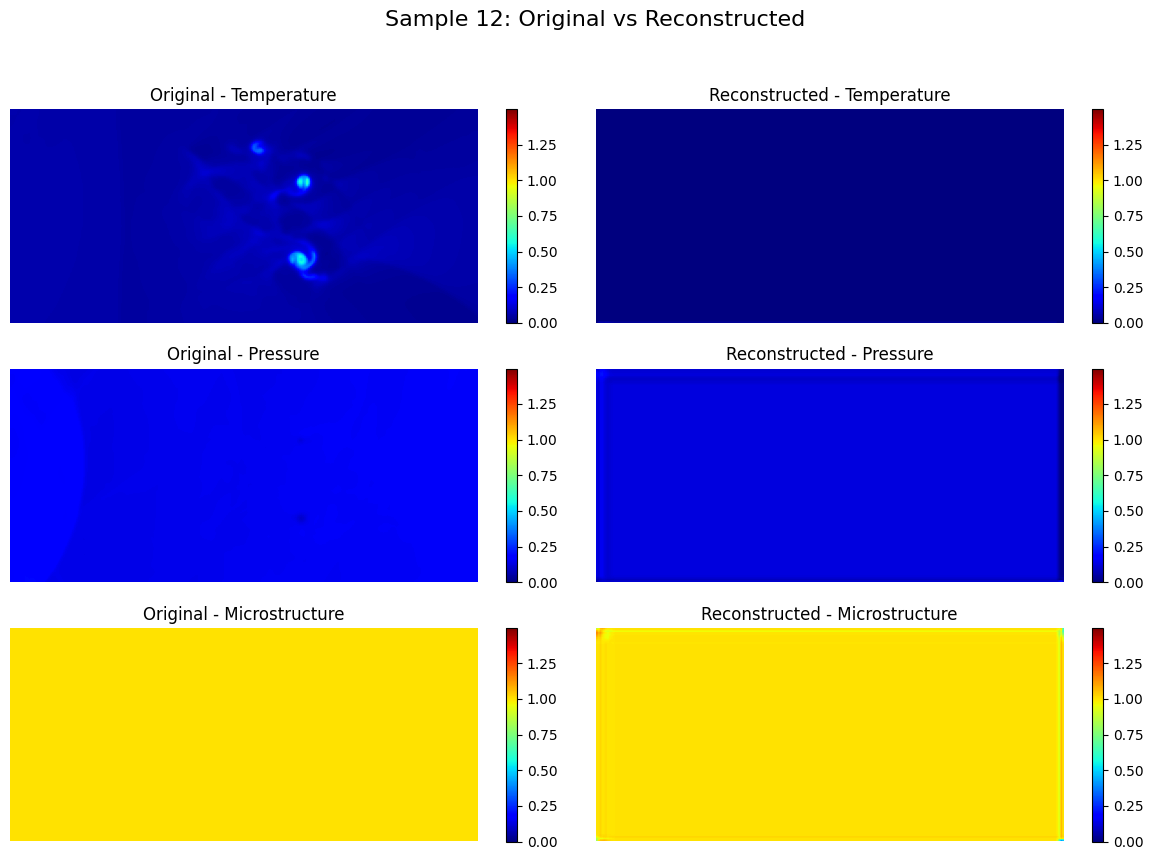

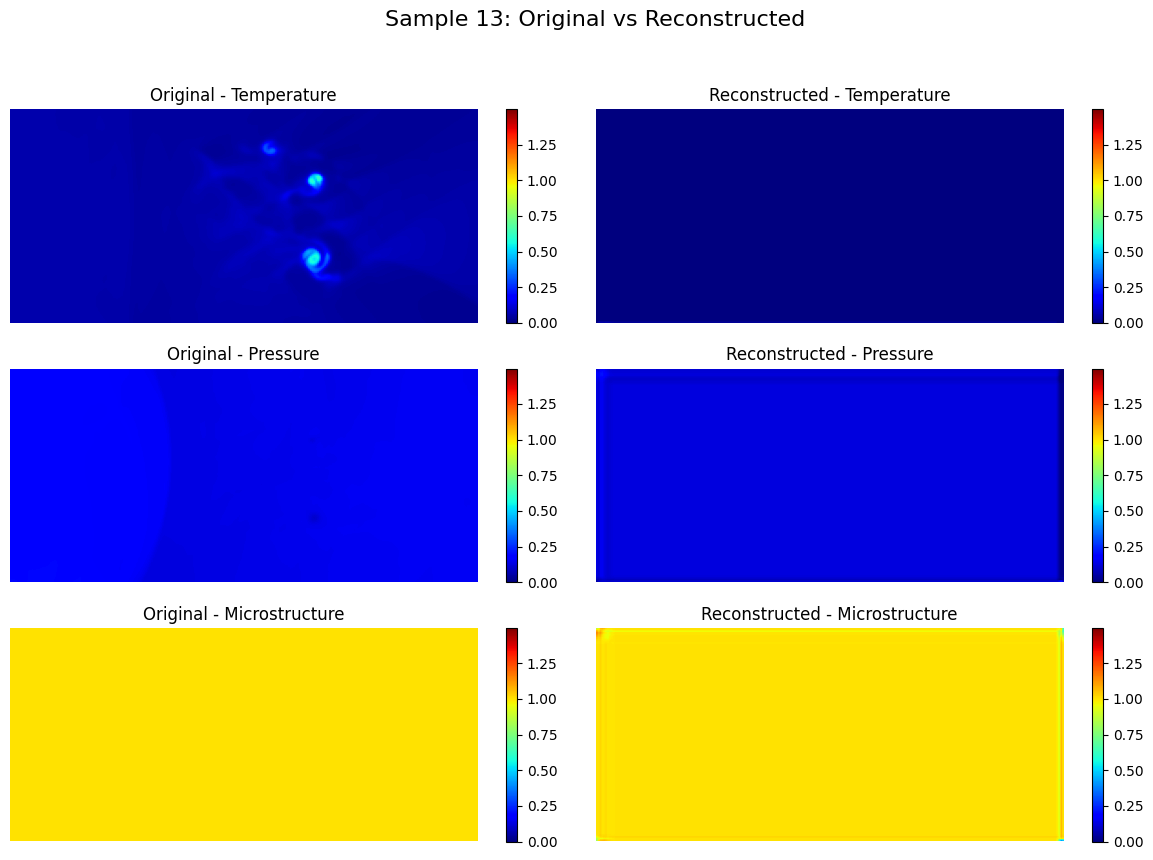

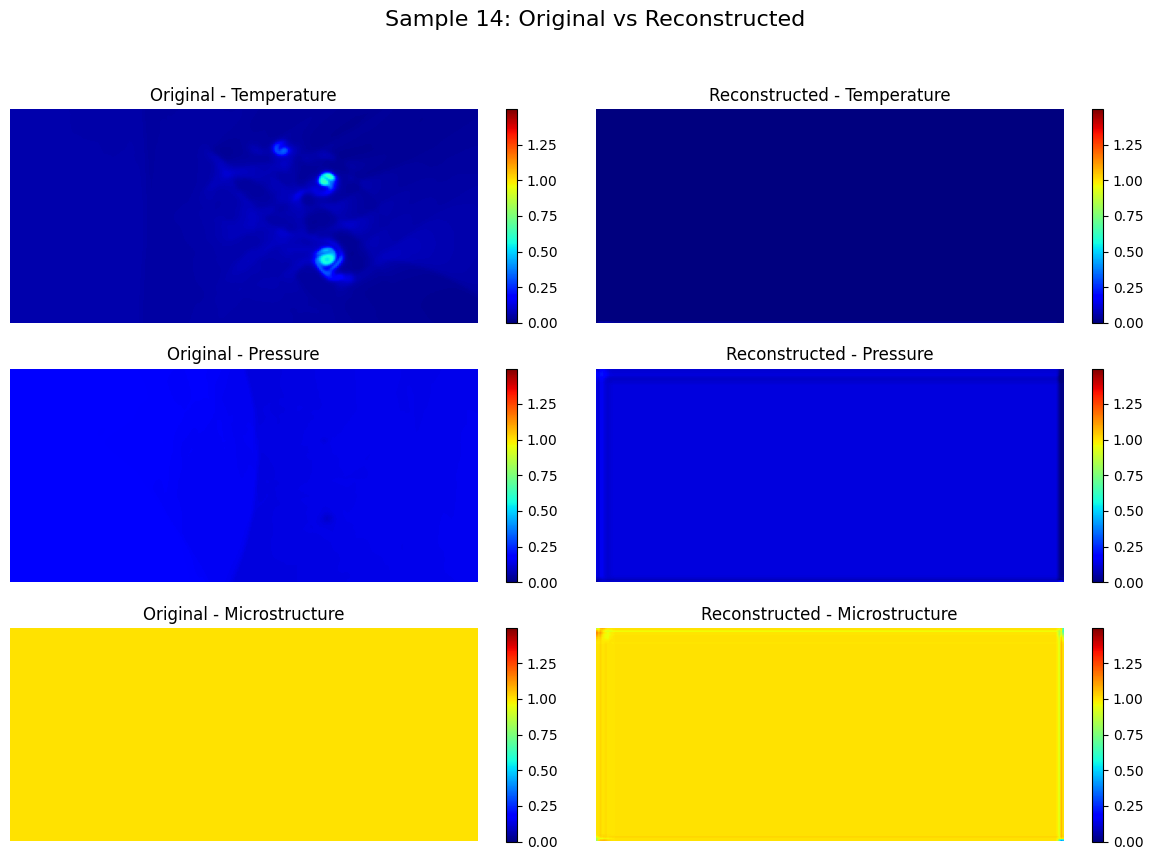

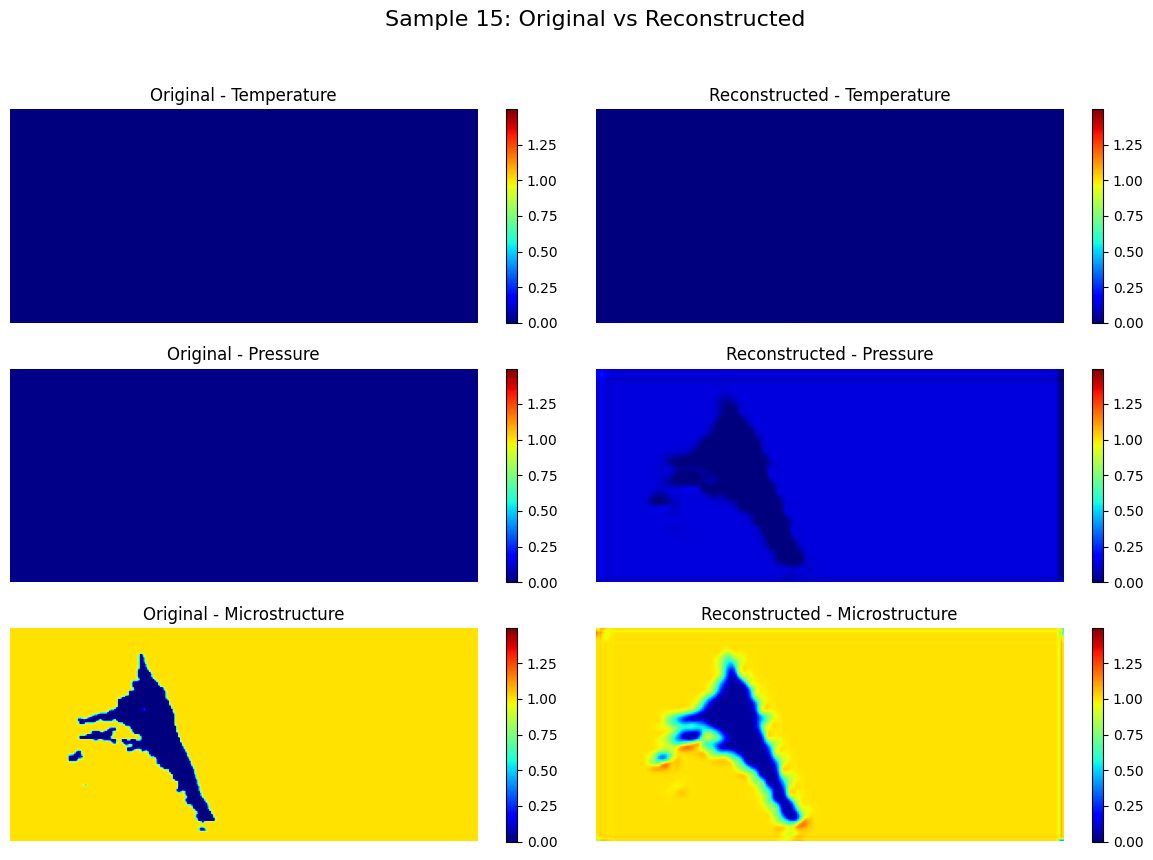

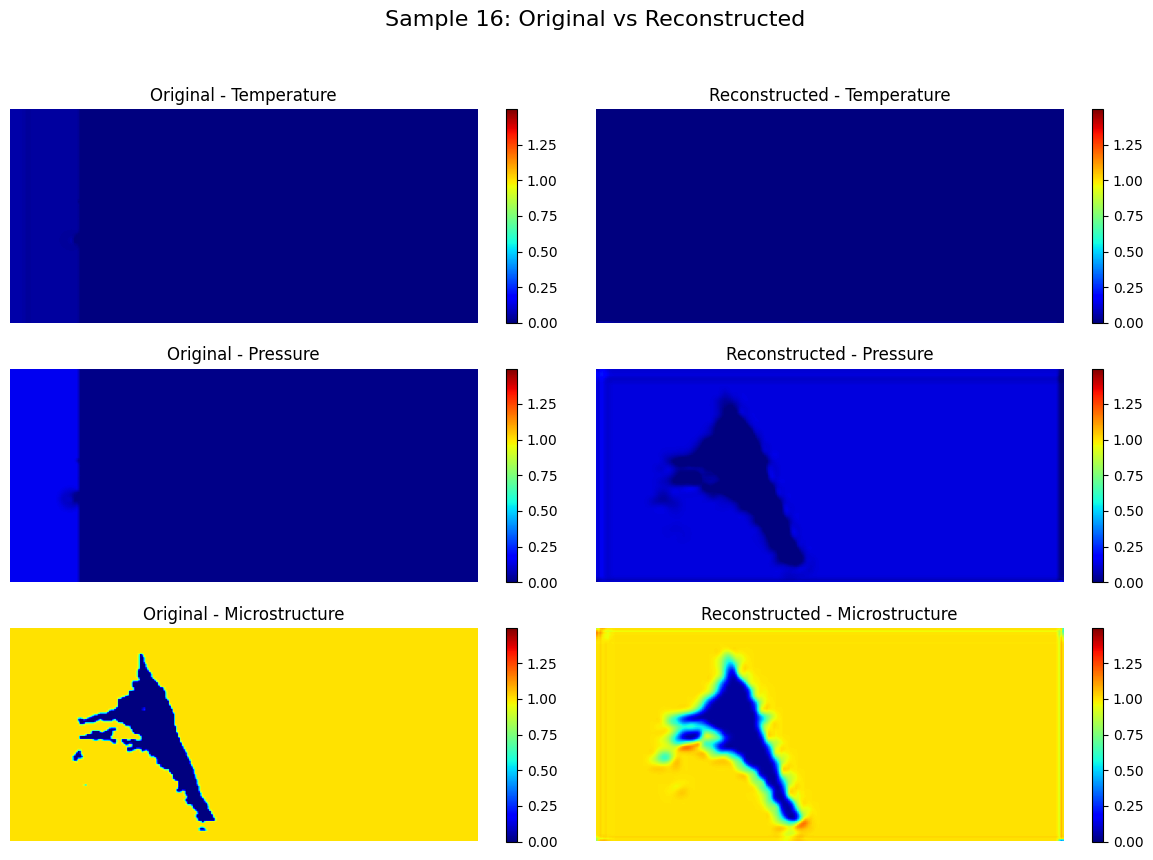

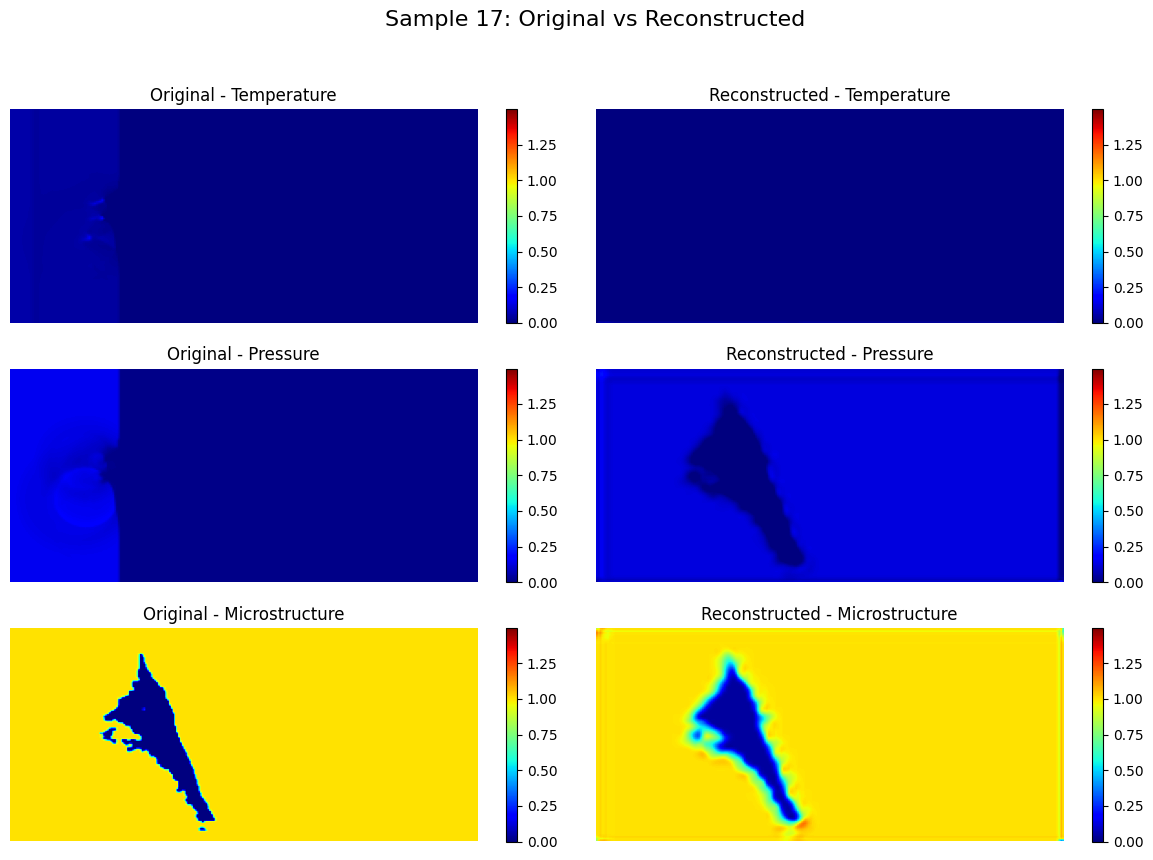

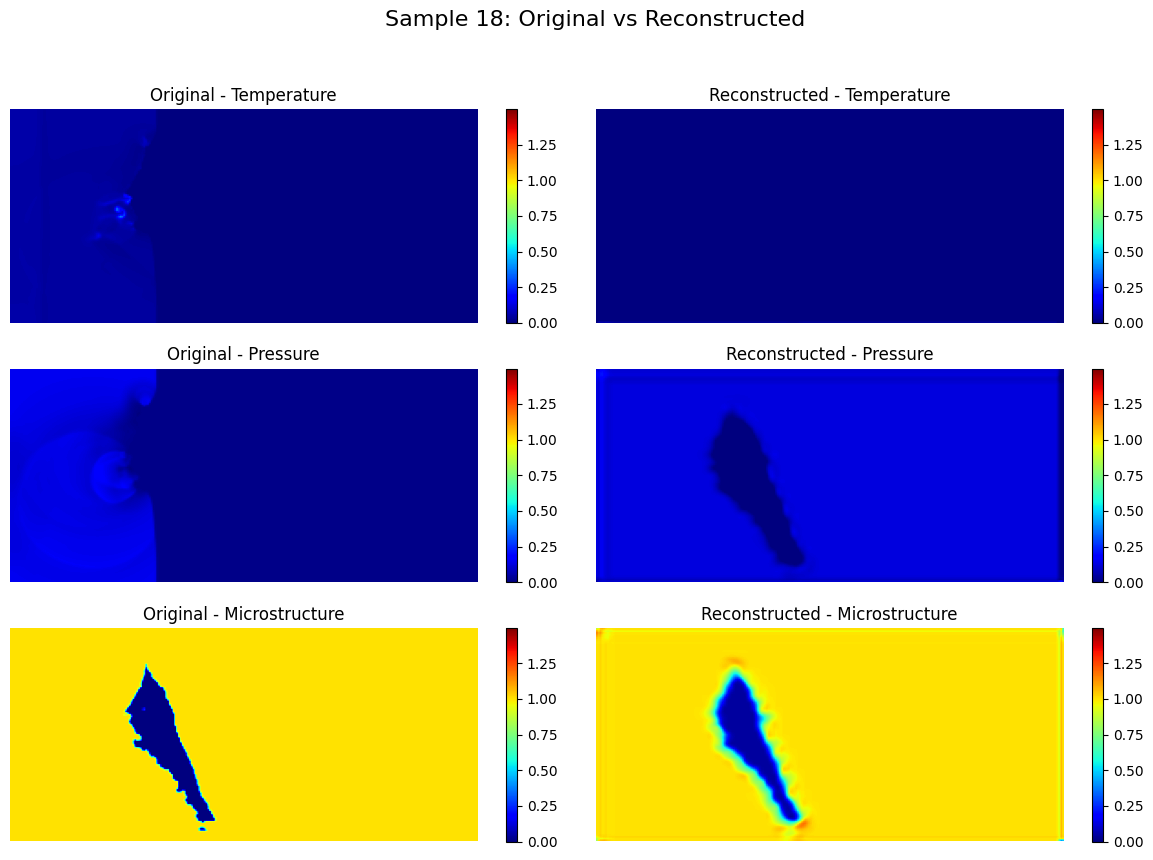

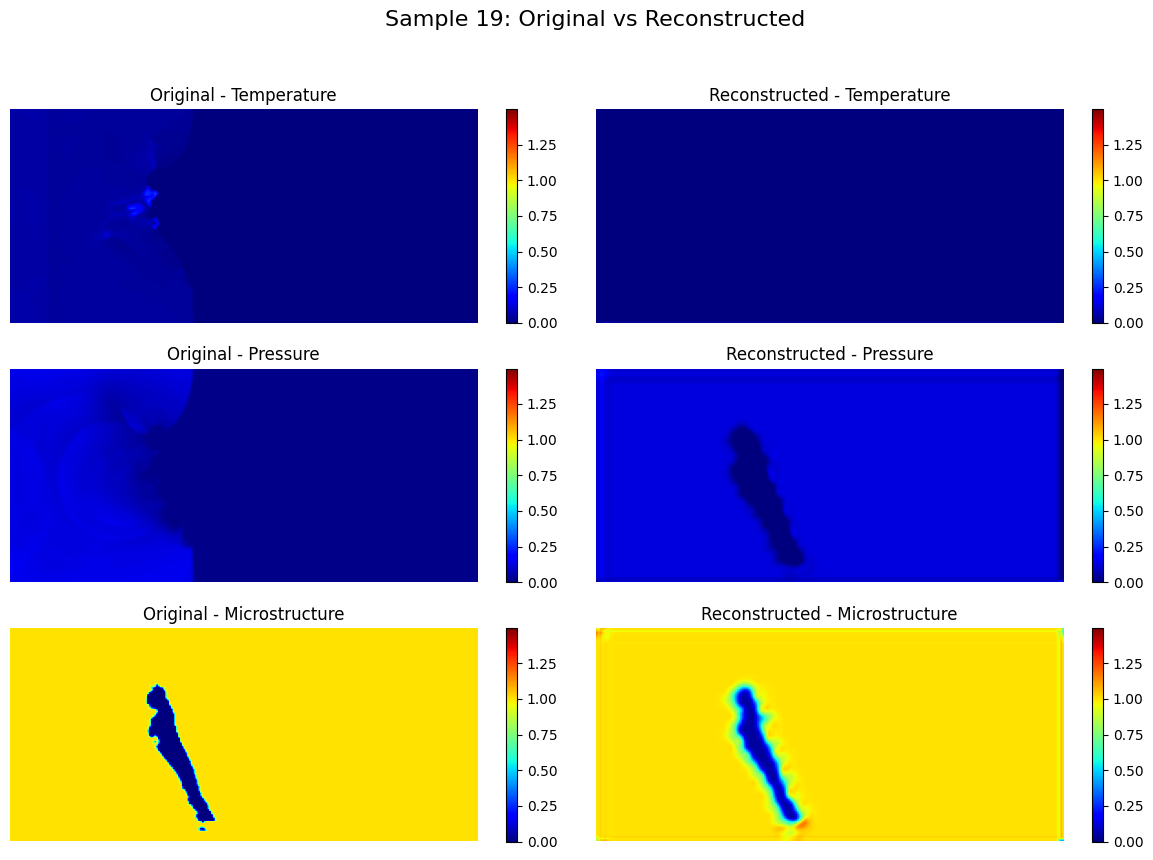

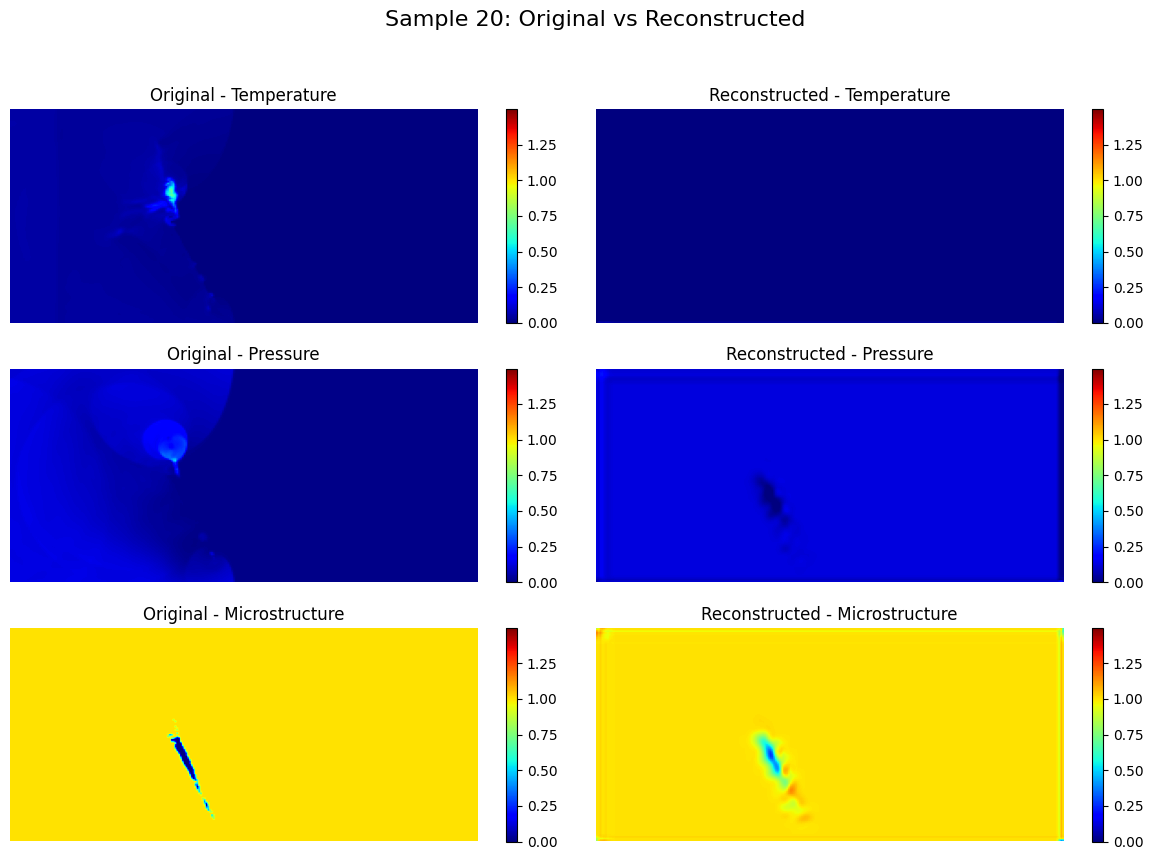

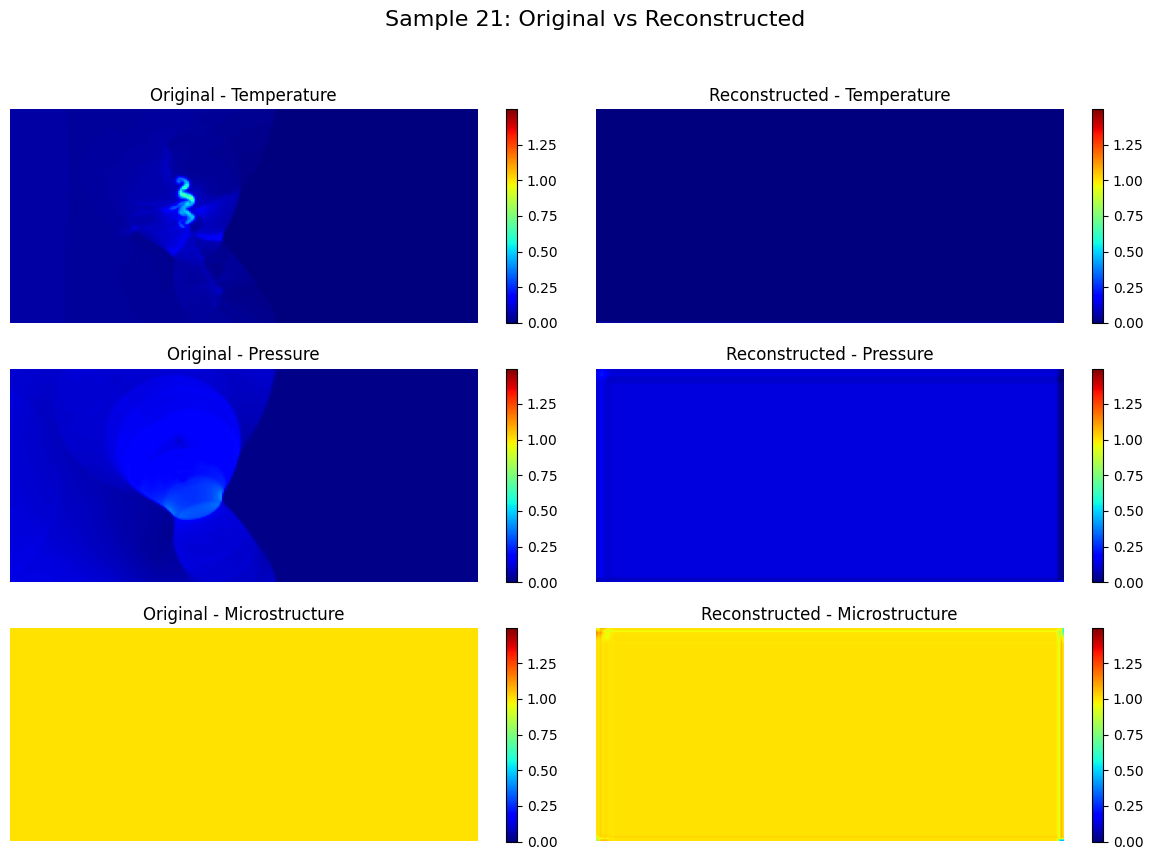

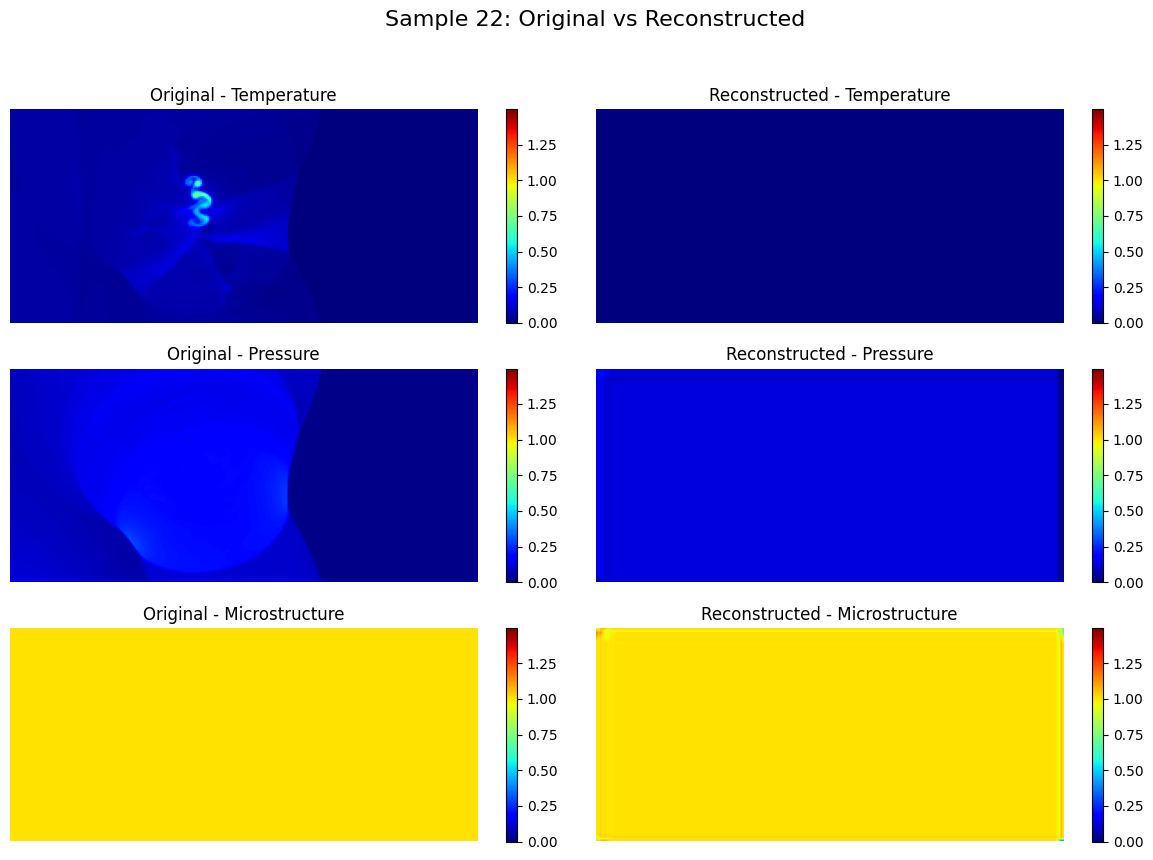

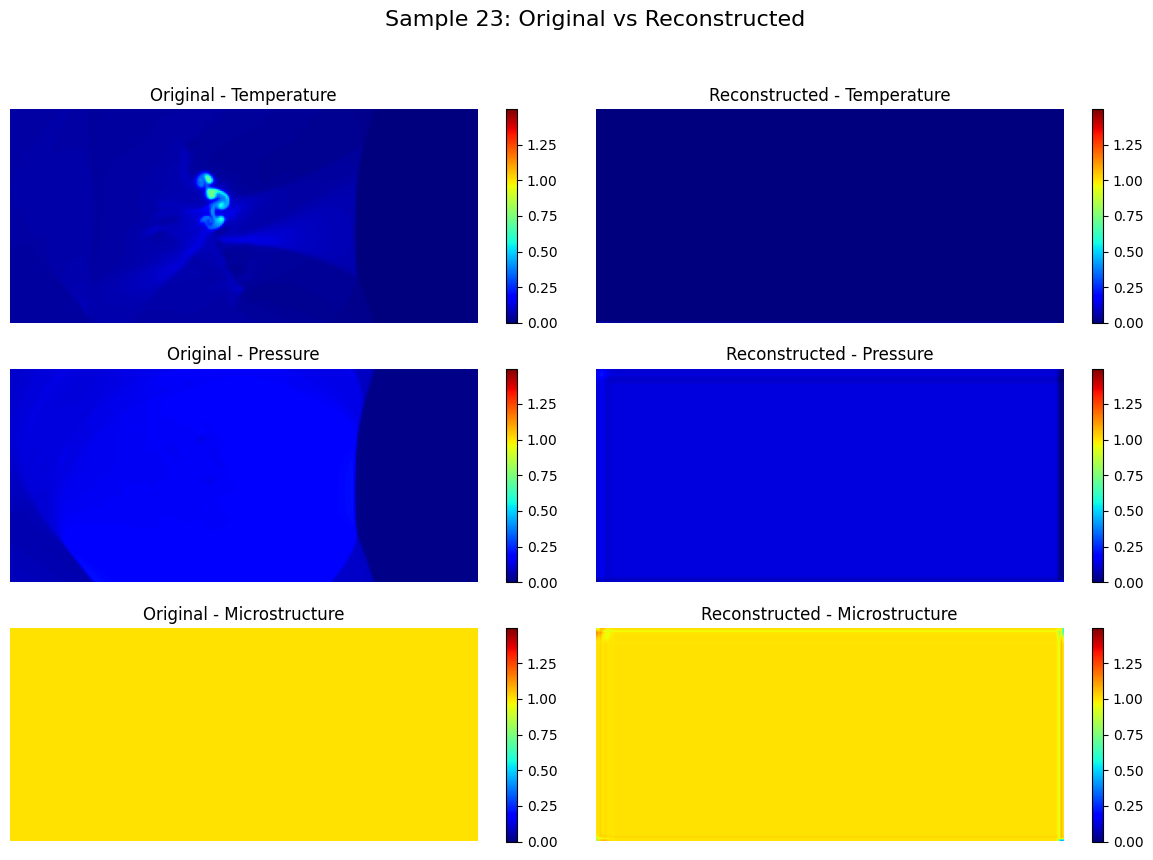

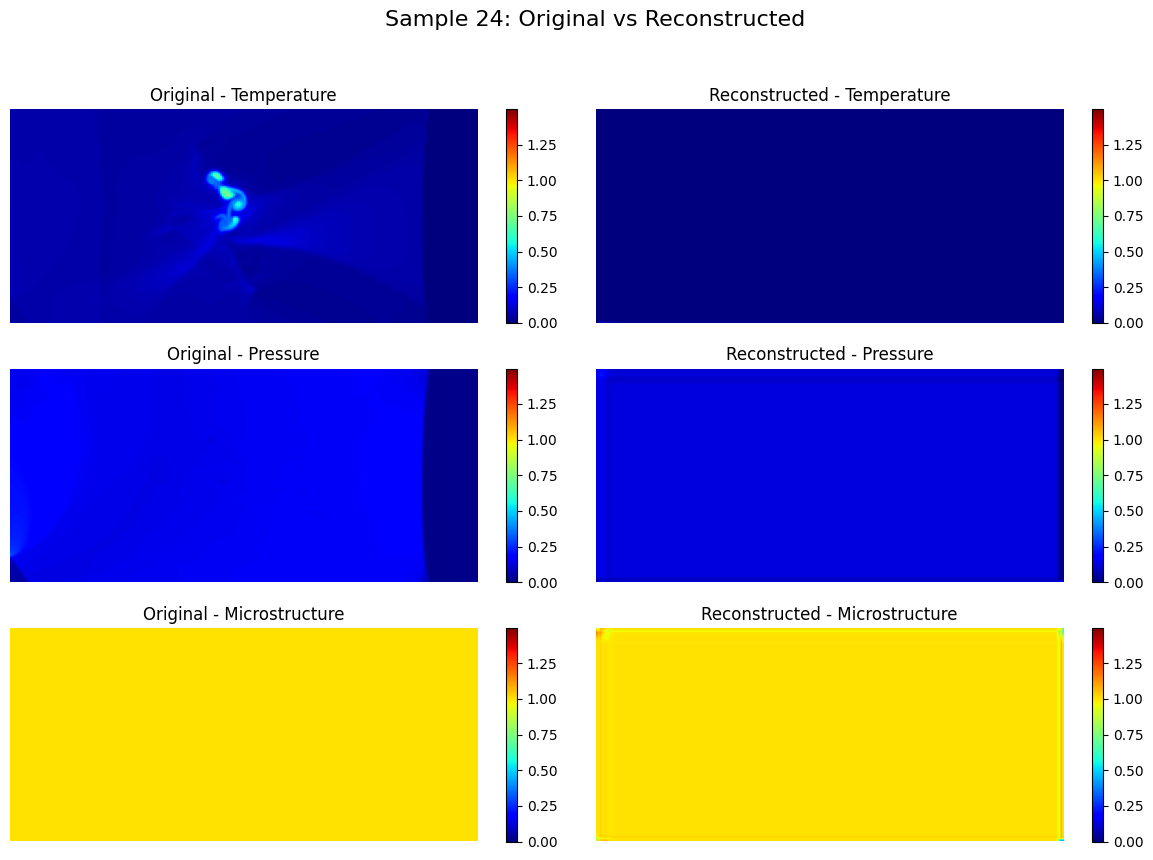

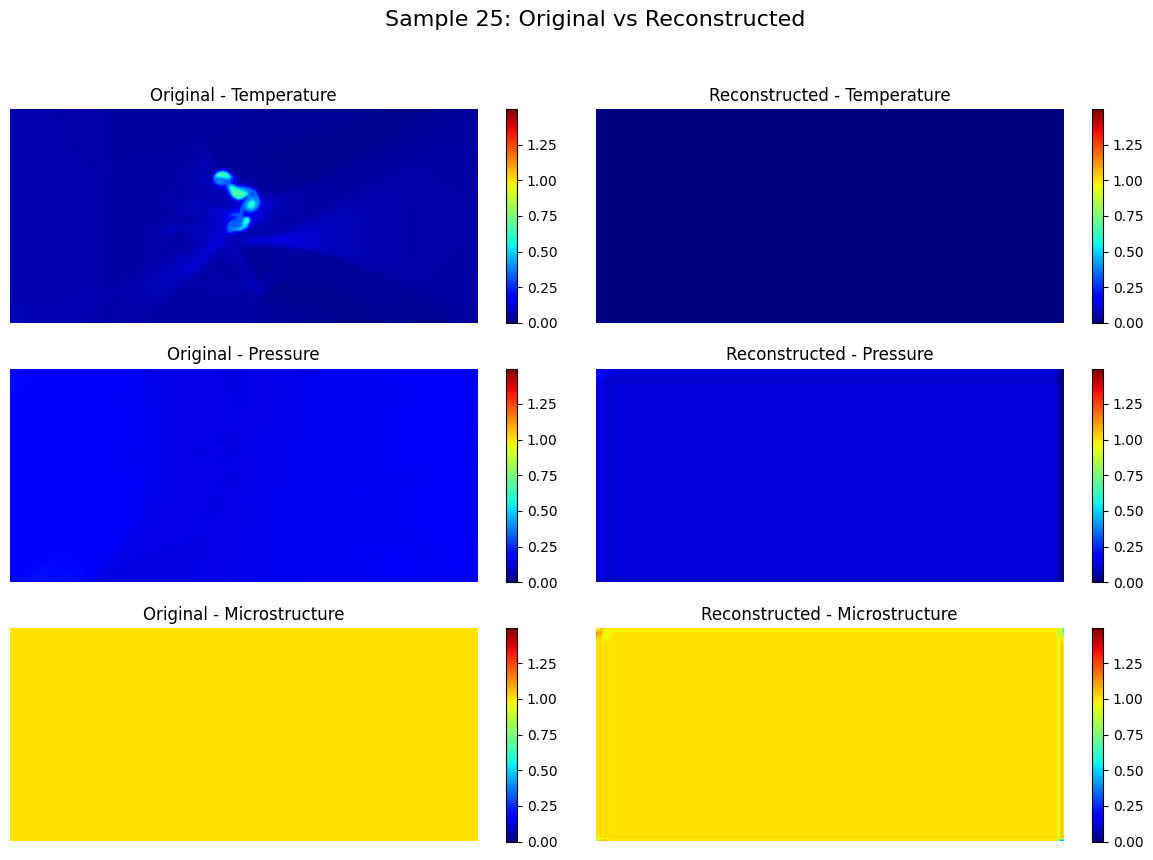

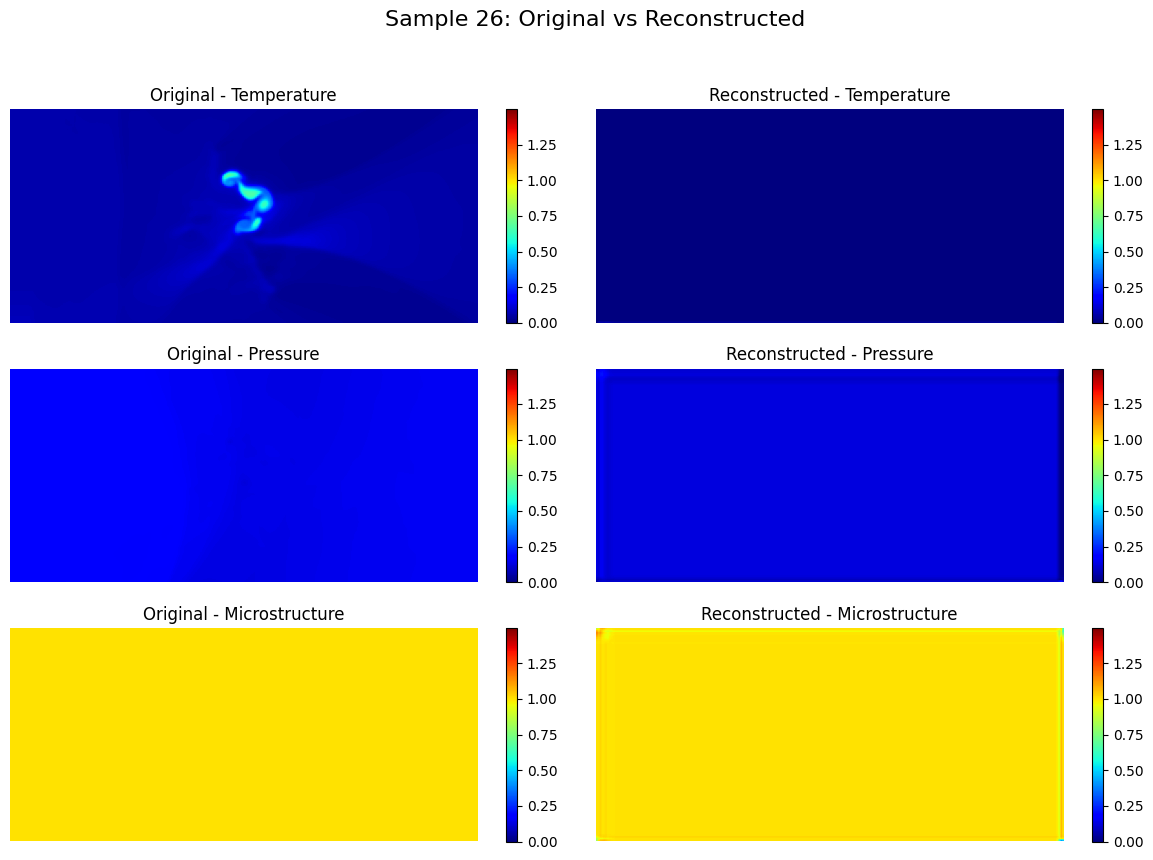

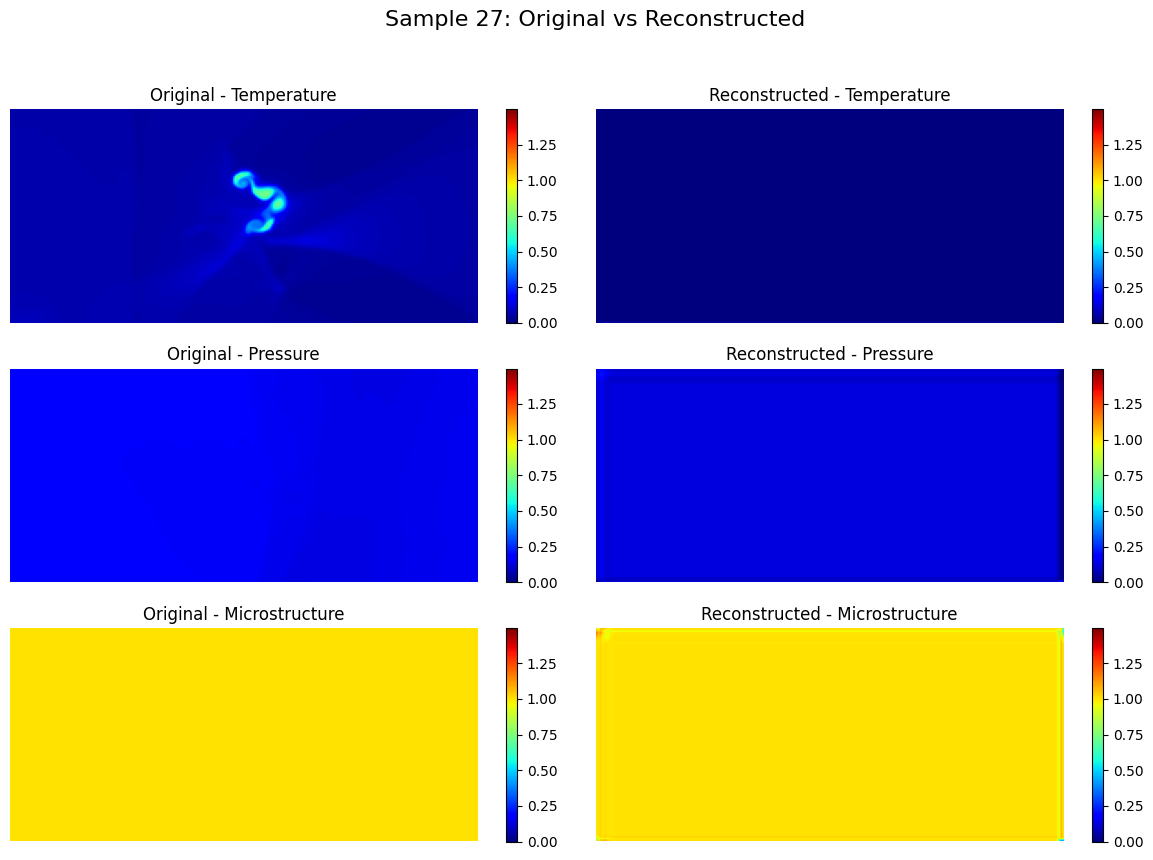

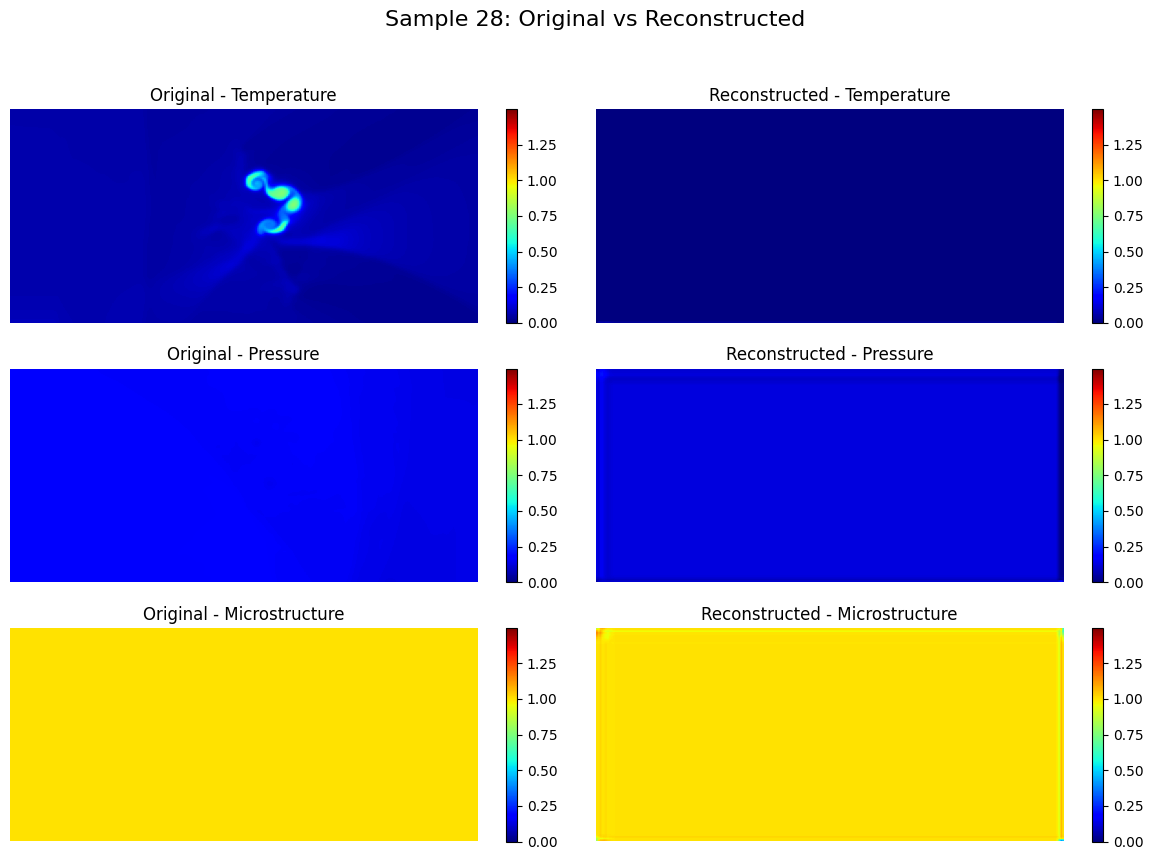

In [12]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
num_samples = min(28, just_AE_reconstruction_GT.shape[0])  # Display up to 5 samples or fewer if dataset is smaller

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(just_AE_reconstruction_GT.min(), just_AE_reconstruction_pred.min())
global_max = max(just_AE_reconstruction_GT.max(), just_AE_reconstruction_pred.max())

# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Original channel
        original_channel = just_AE_reconstruction_GT[sample_idx, channel_idx, :, :].numpy()
        # Reconstructed channel
        reconstructed_channel = just_AE_reconstruction_pred[sample_idx, channel_idx, :, :].numpy()

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
        
        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
    plt.show()

#### Z hat viz

IndexError: index 6 is out of bounds for axis 0 with size 6

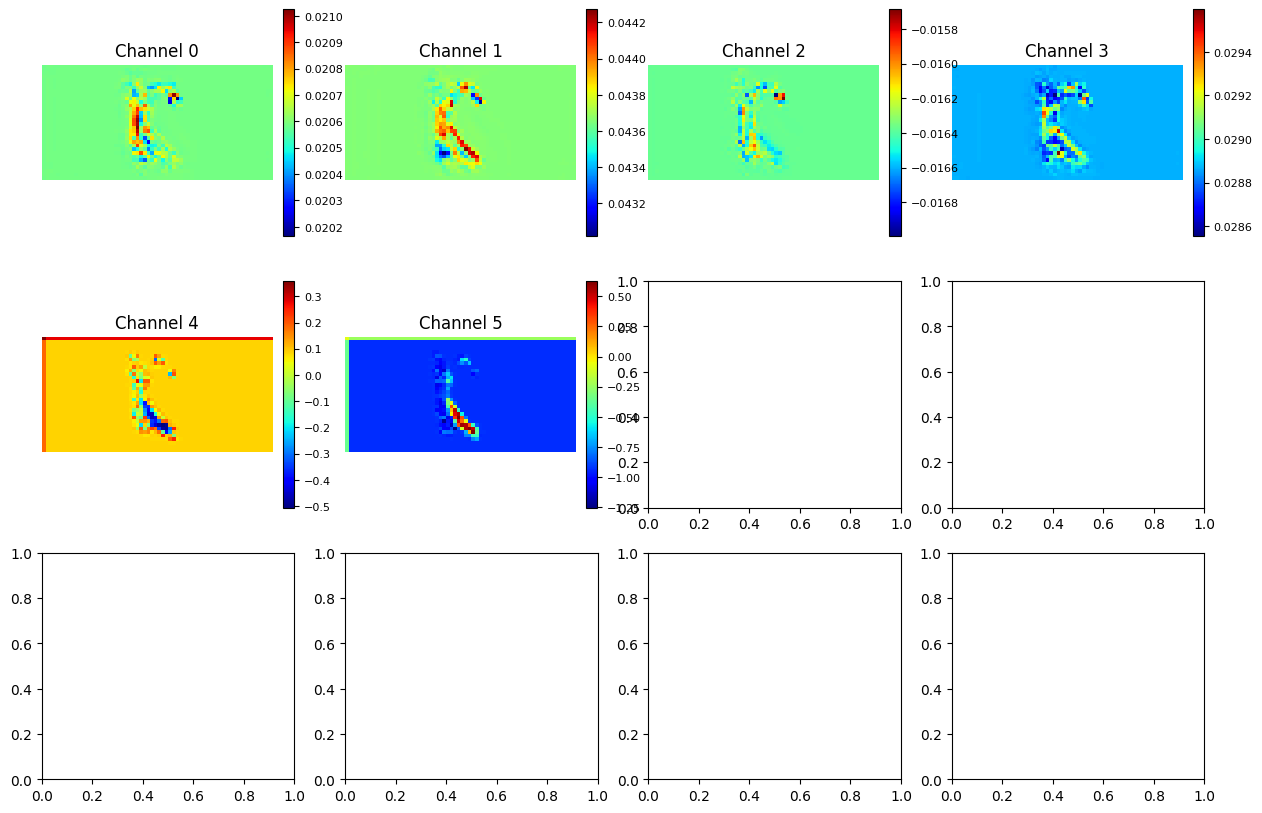

In [13]:
import torch
import matplotlib.pyplot as plt

# Assuming single_ts_Zhat is already loaded as a tensor of shape [476, 16, 32, 64]
# Set index i (change this as needed)
i = 4

# Extract the 16-channel image at index i
images = single_ts_Zhat[i]  # Shape: [16, 32, 64]

# Convert to CPU and numpy for visualization
images = images.cpu().detach().numpy()

# Plot all 16 channels in a 4x4 grid with colorbars
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for idx, ax in enumerate(axes.flat):
    if idx < 12:
        im = ax.imshow(images[idx], cmap="jet")
        ax.set_title(f"Channel {idx}")
        ax.axis("off")

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)  # Adjust tick label size

plt.tight_layout()
plt.show()

#### Full LatentPARC Reconstruction Evaluation (SNAPSHOT SINGLE TS)

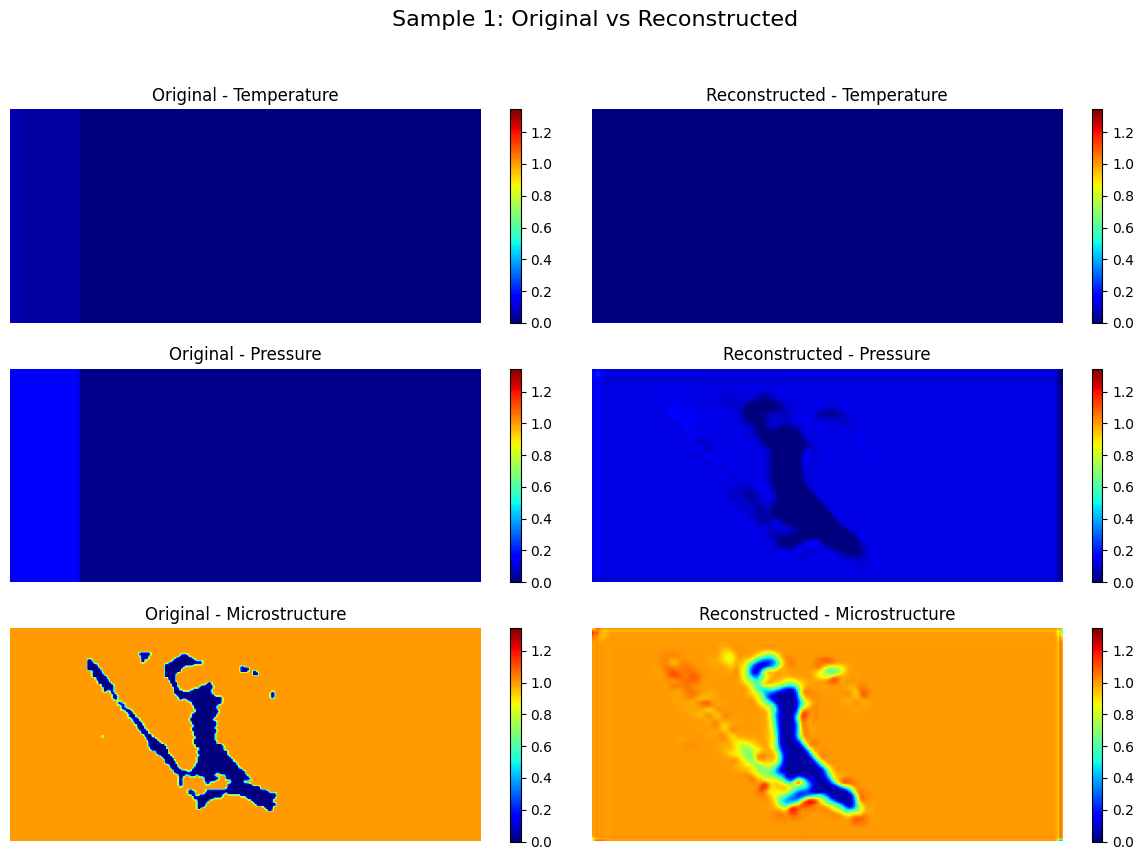

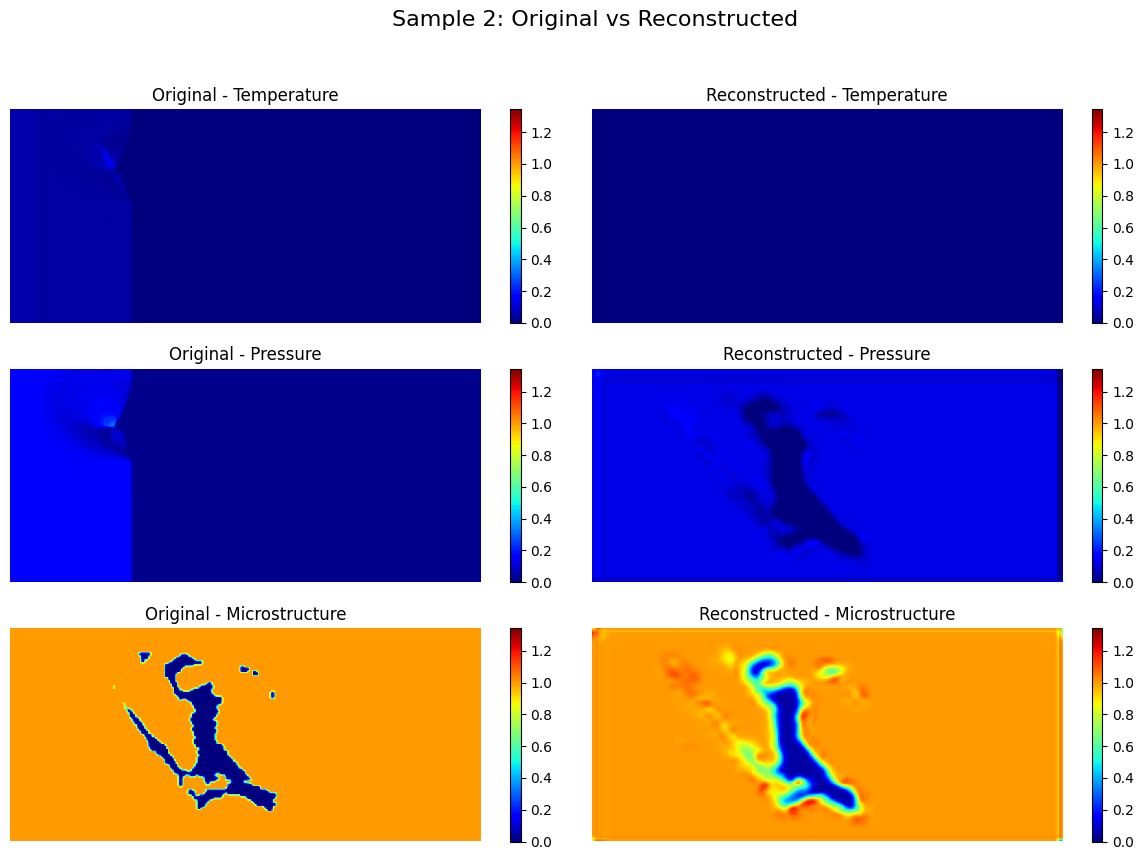

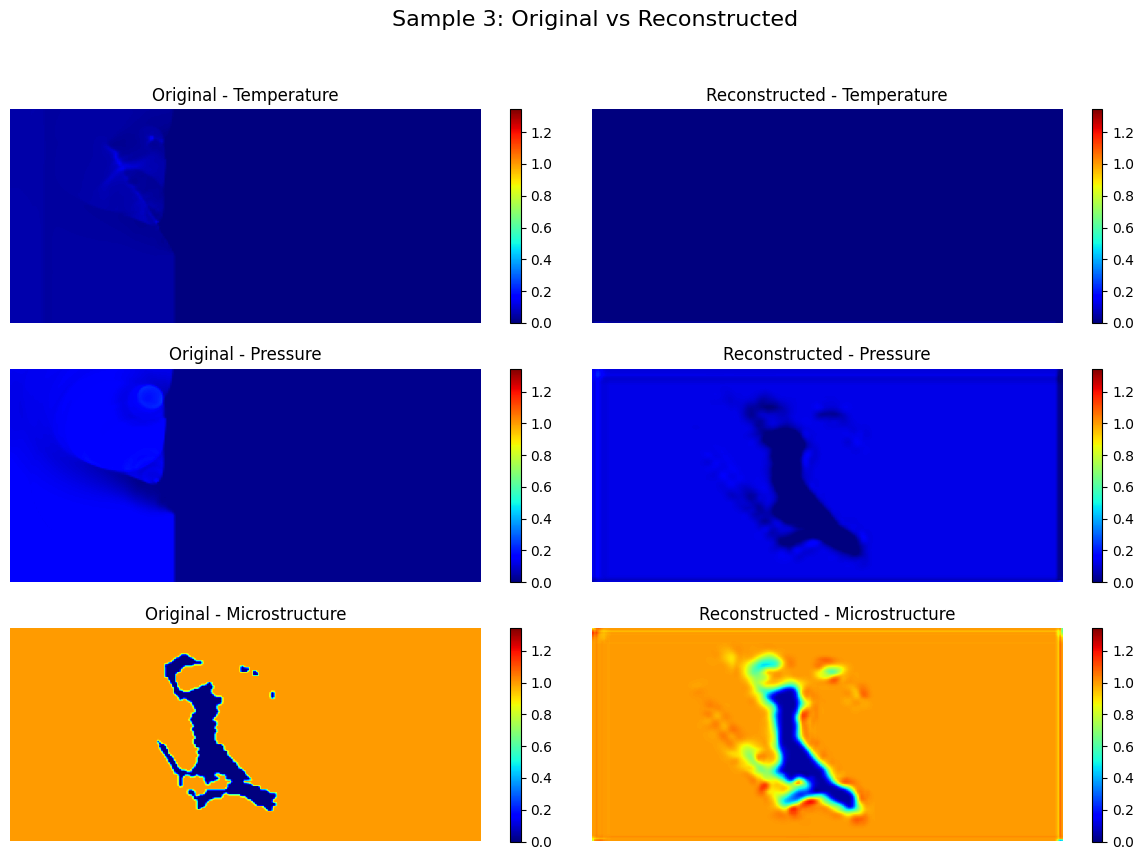

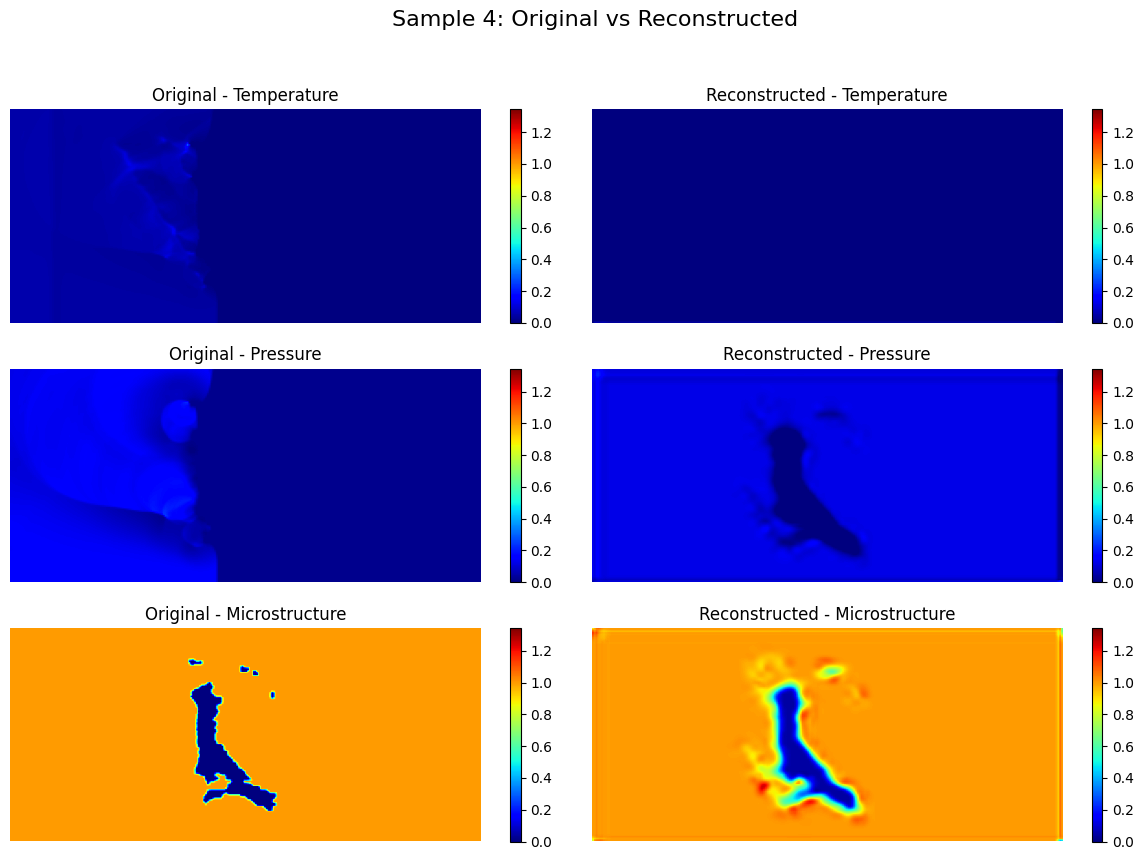

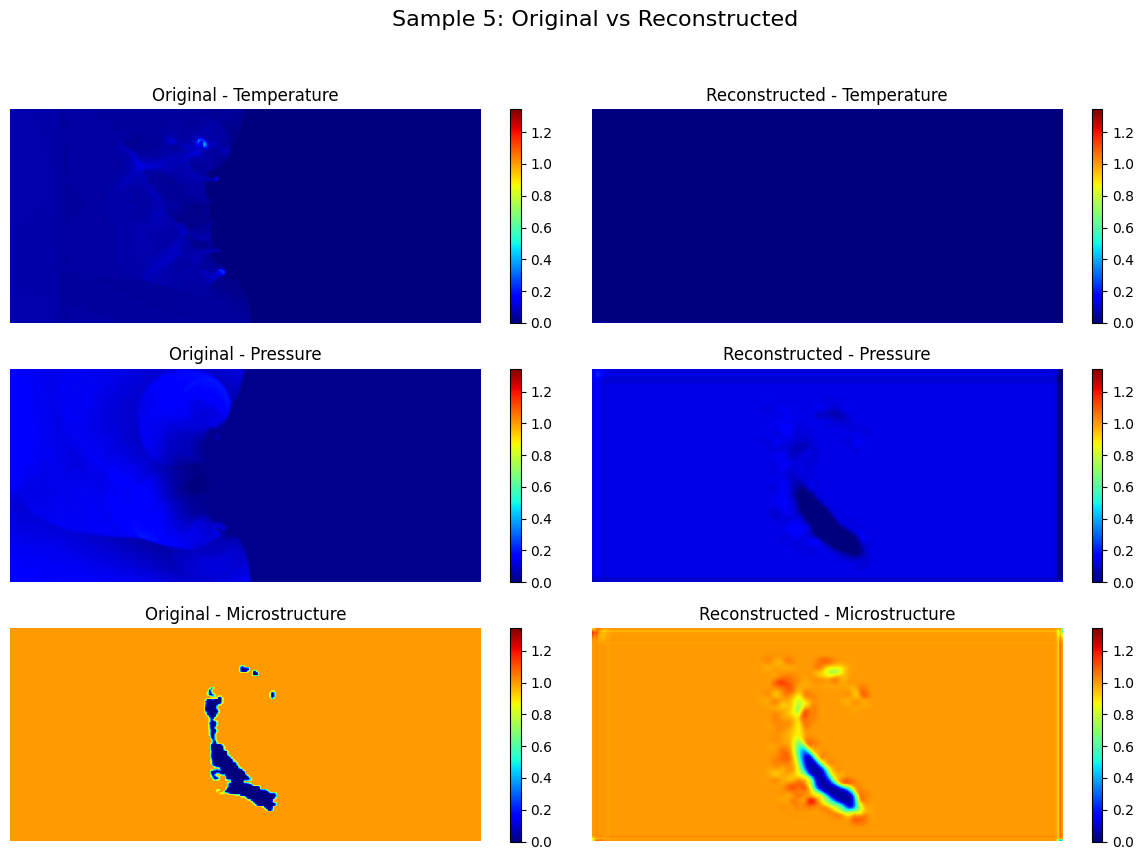

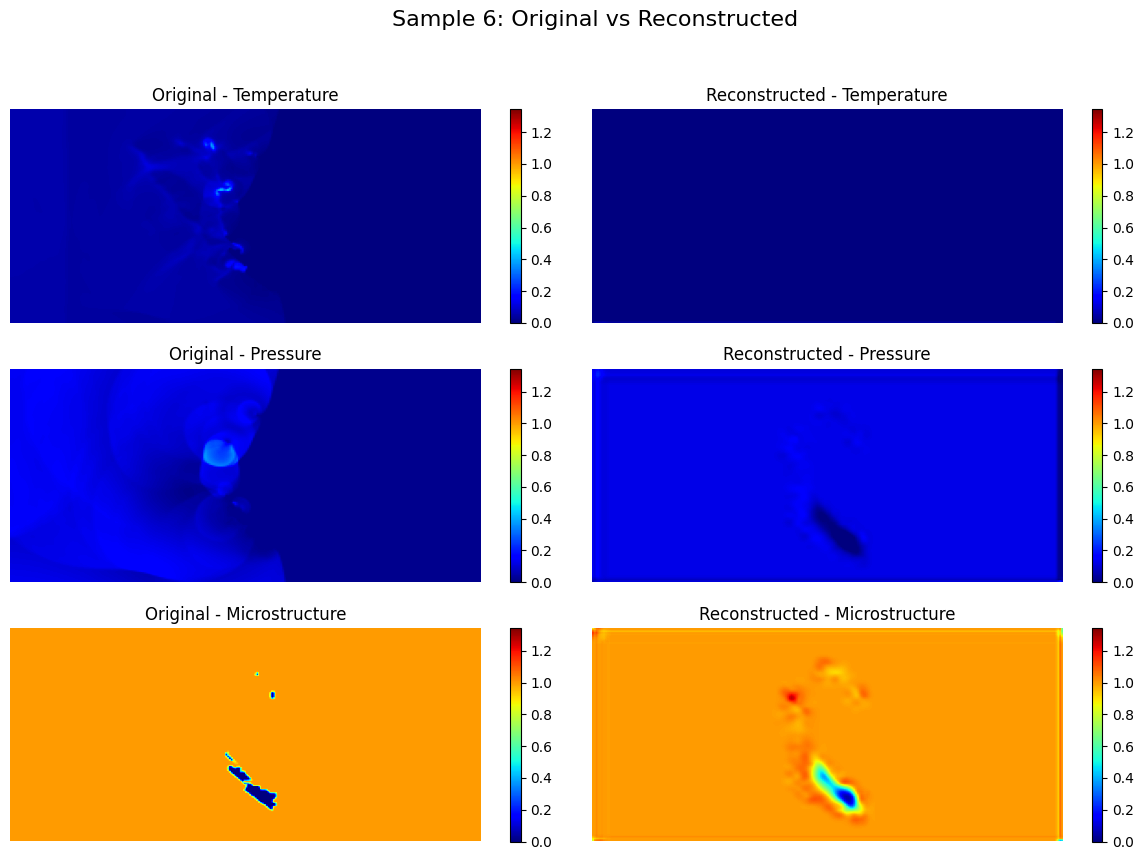

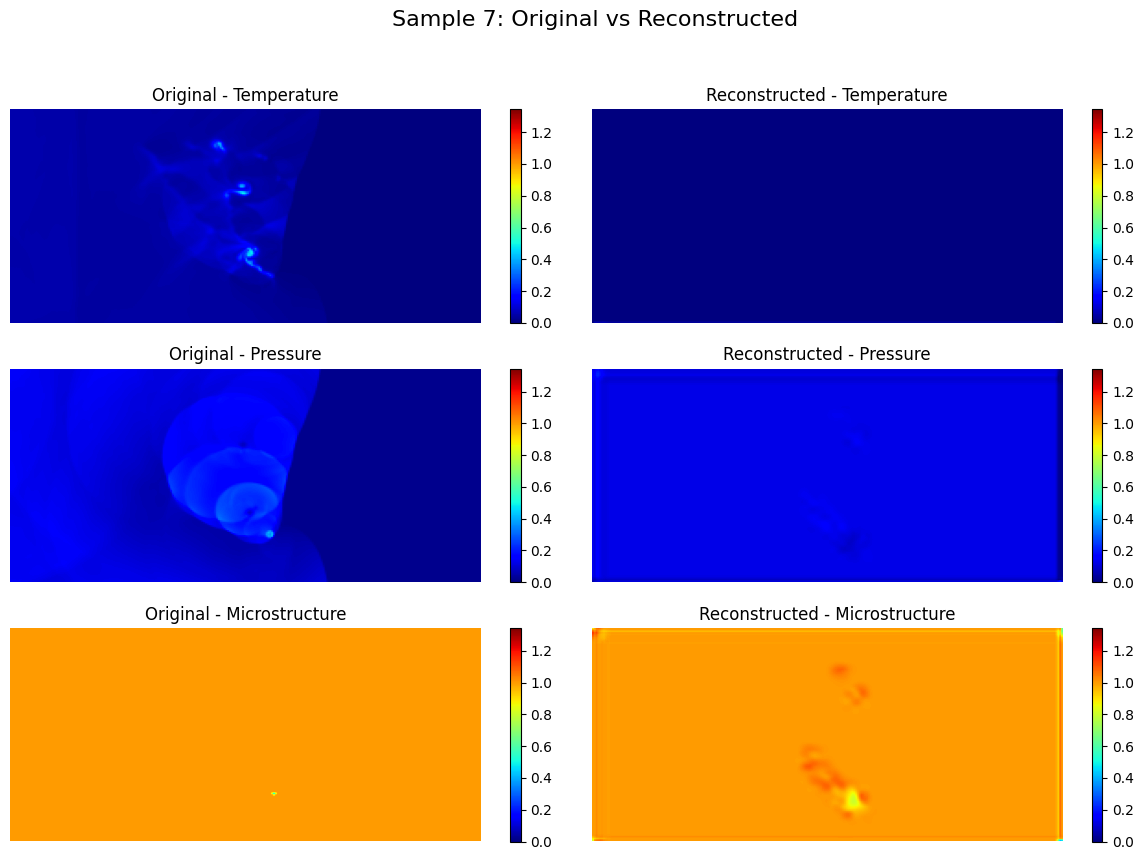

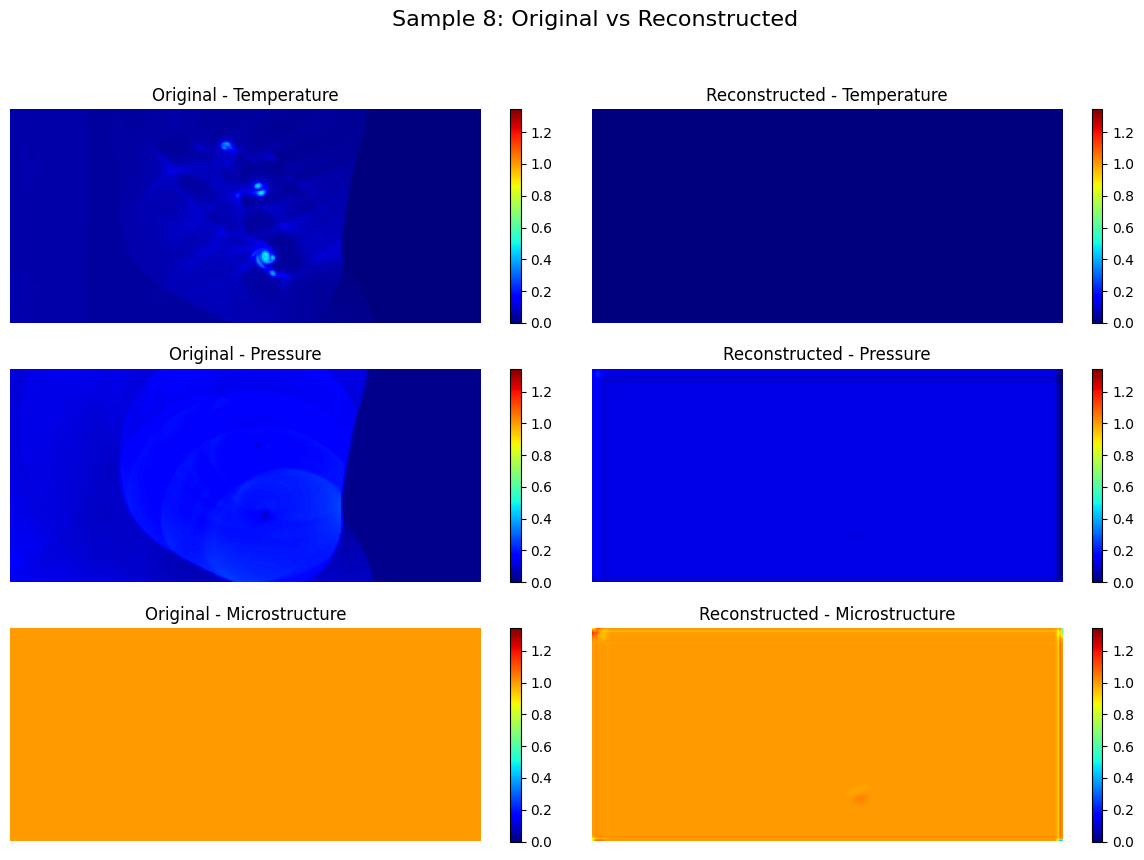

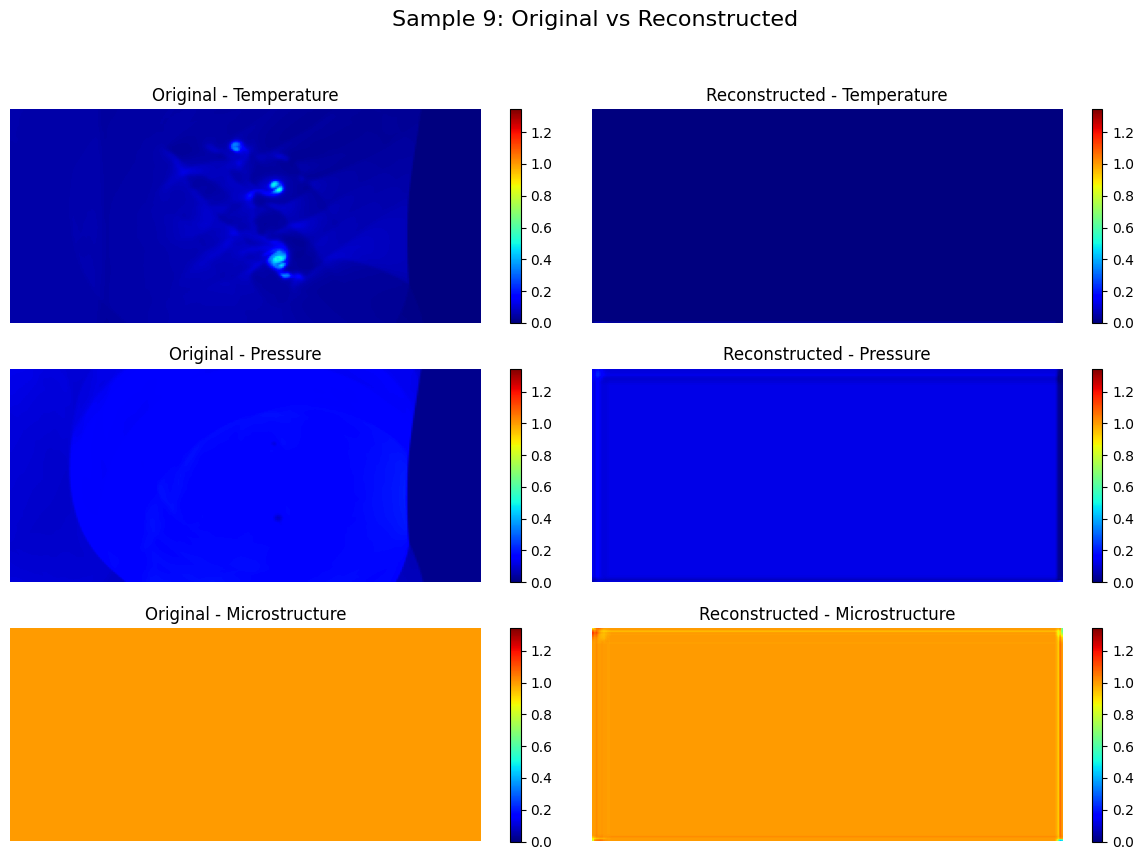

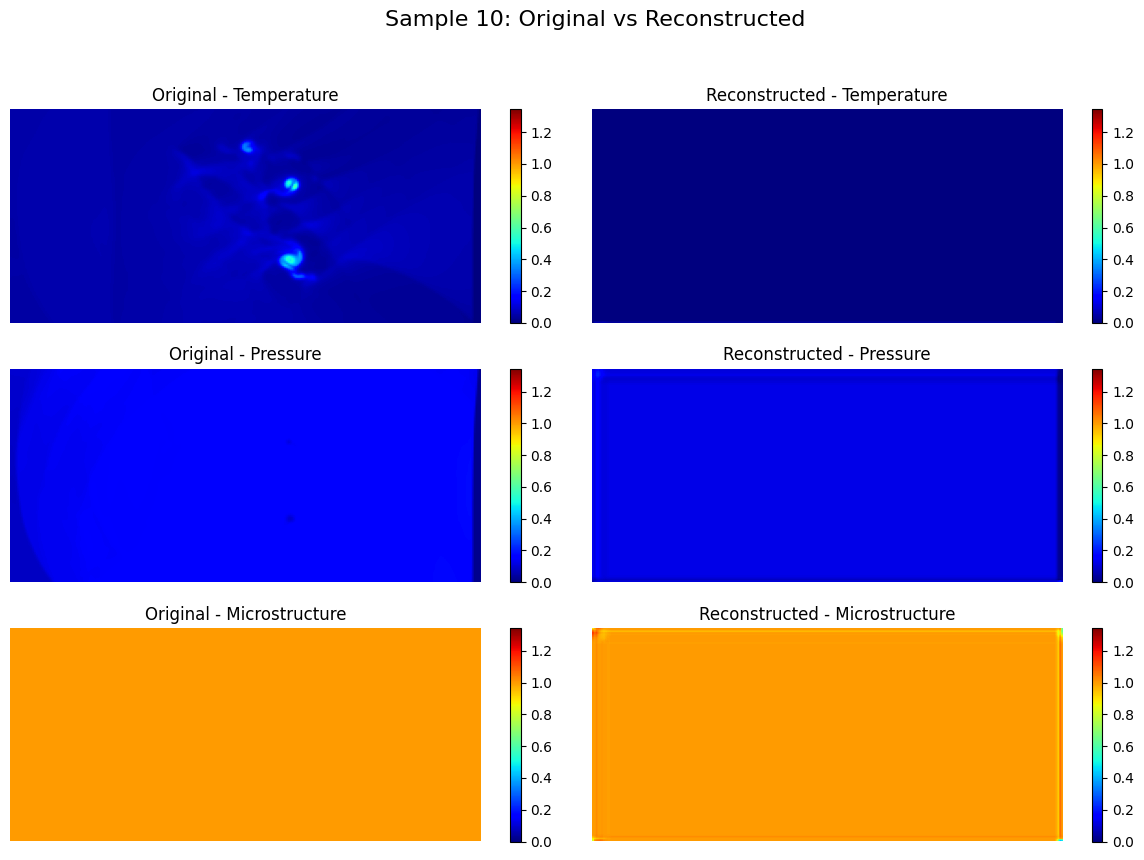

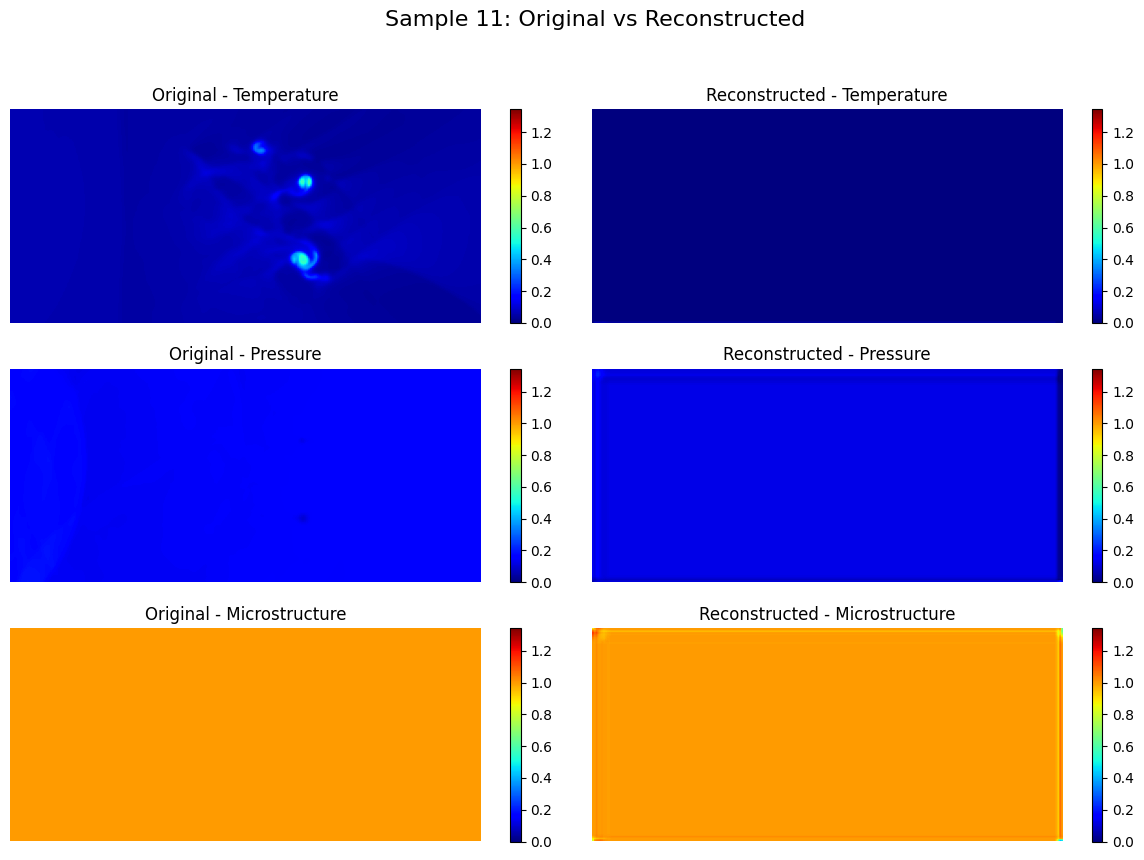

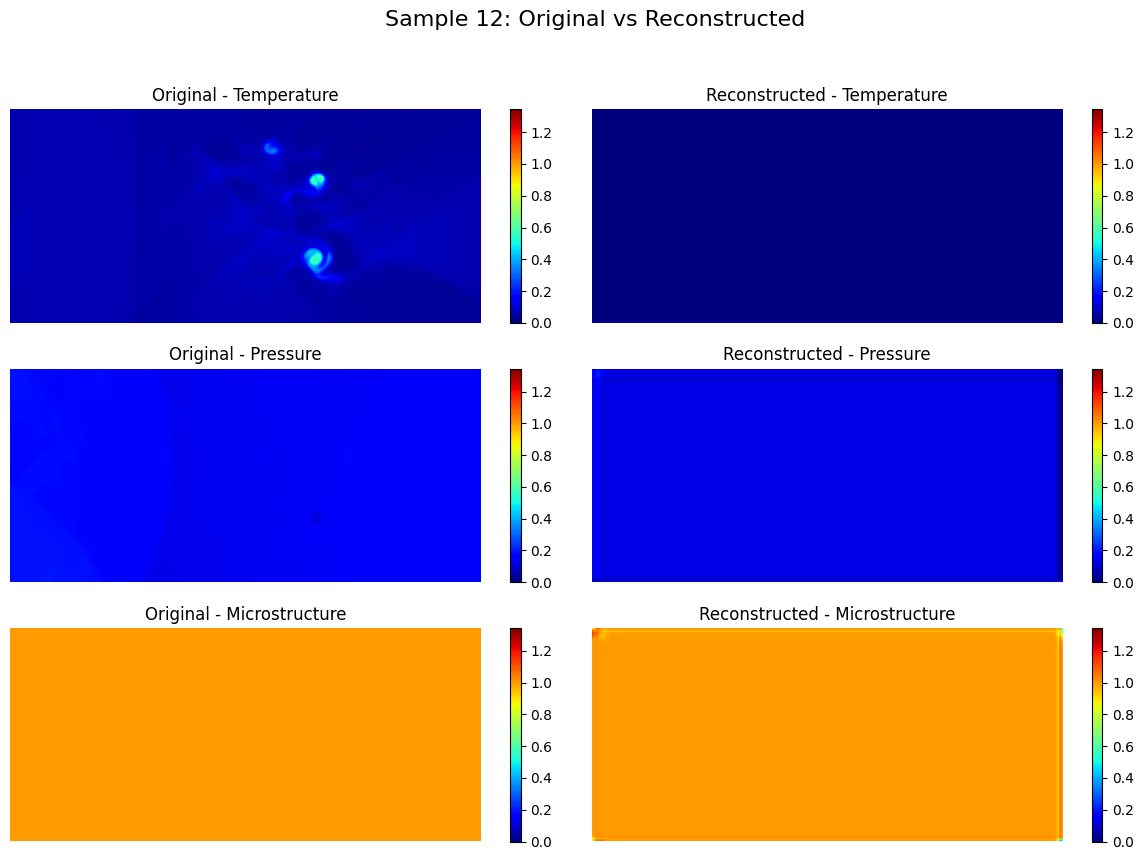

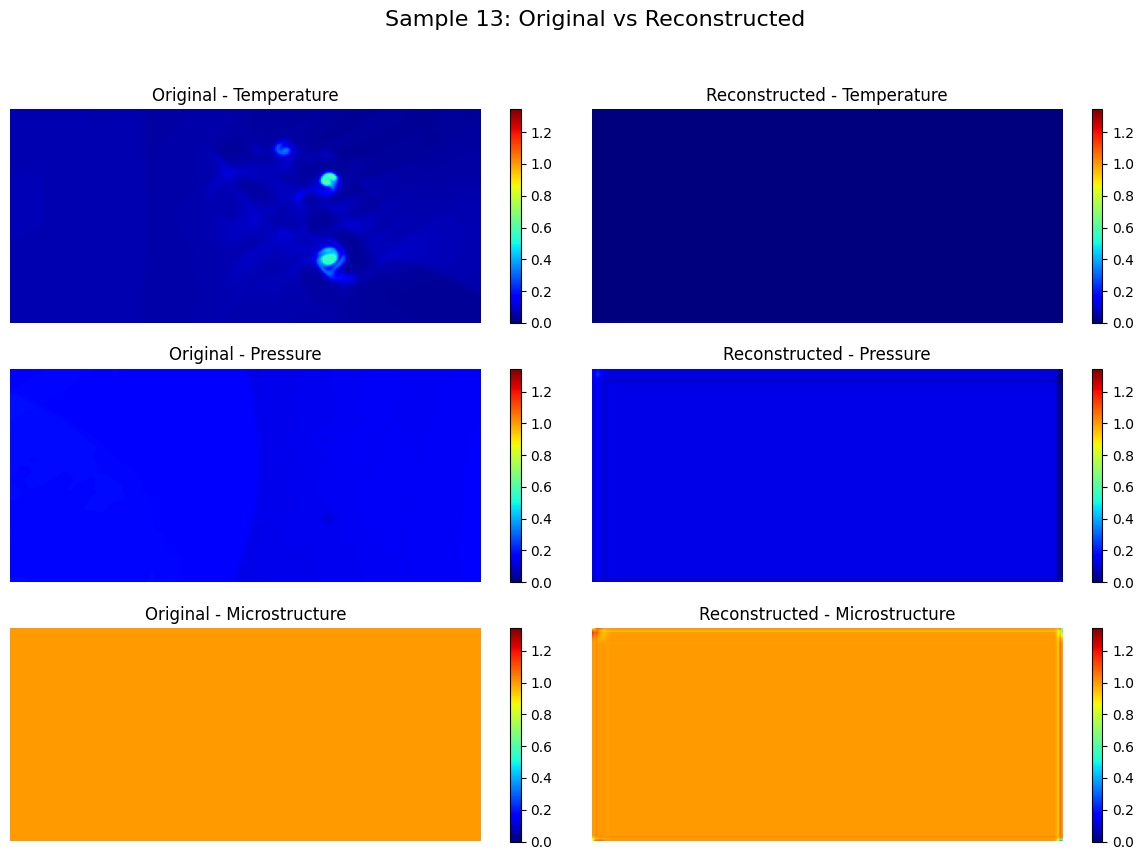

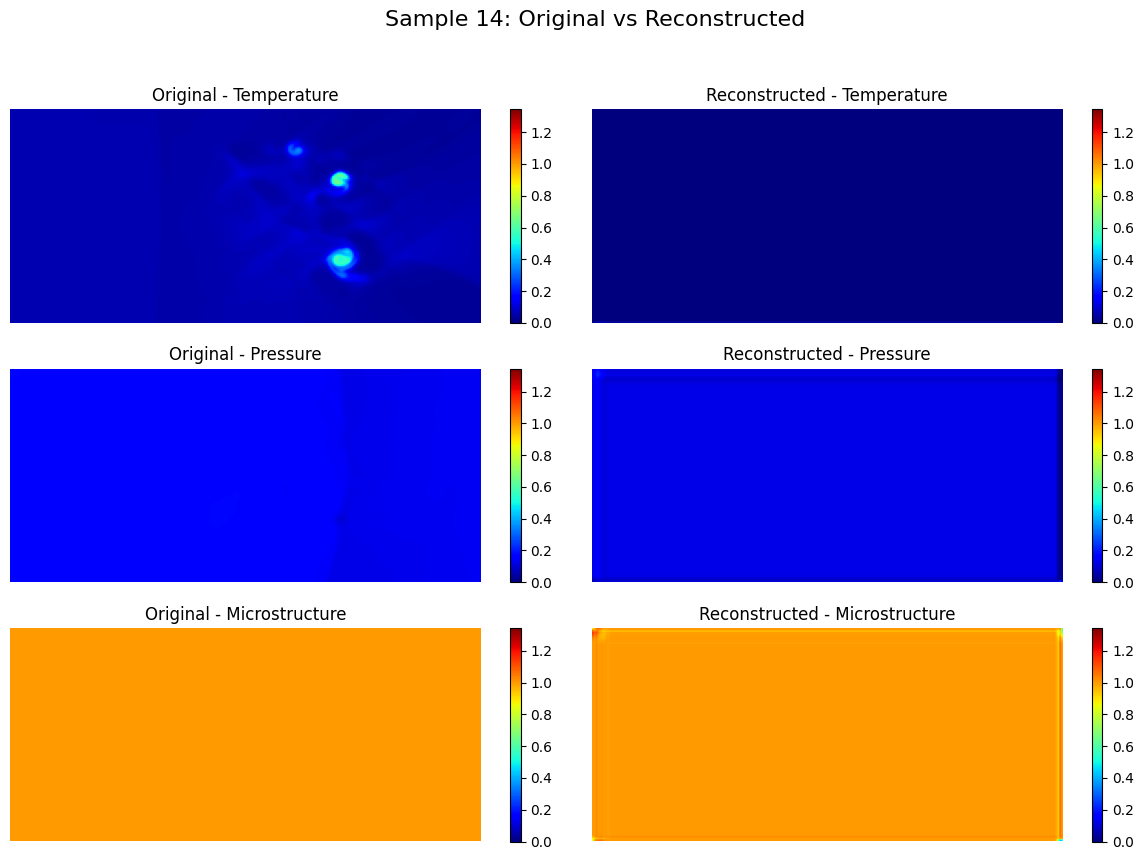

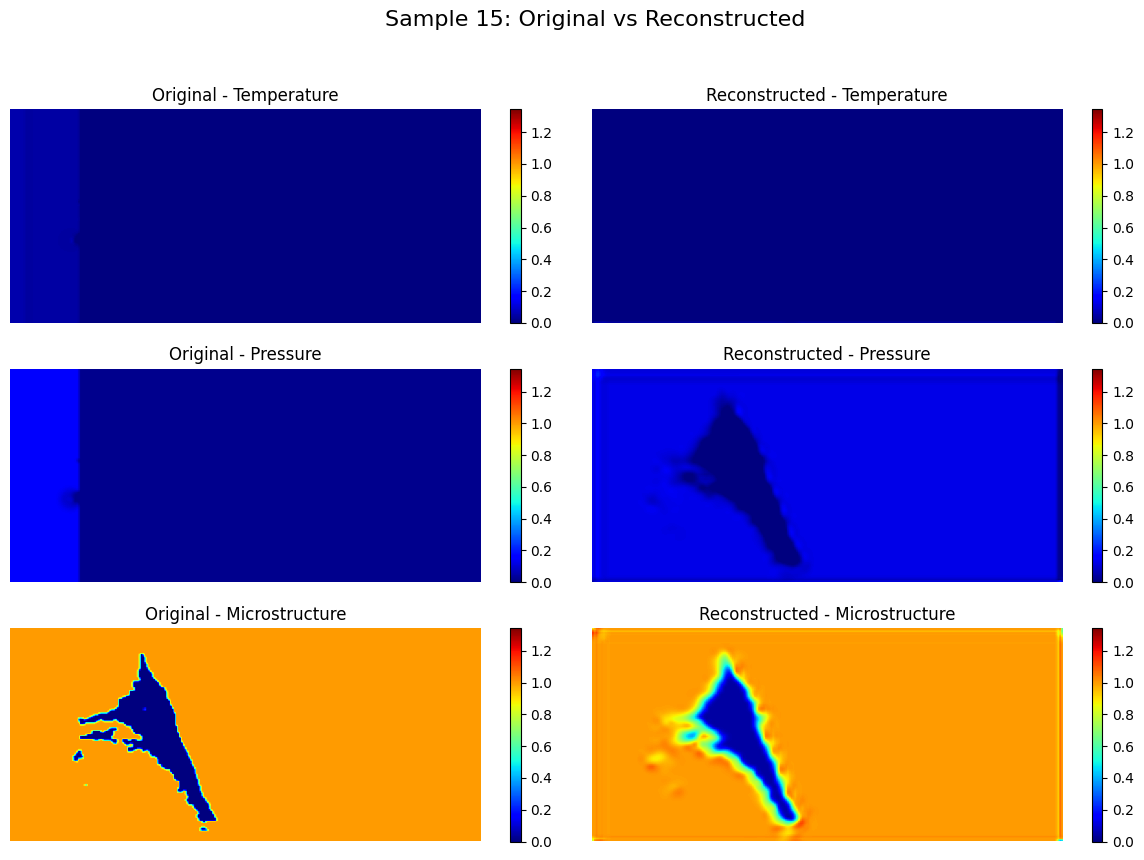

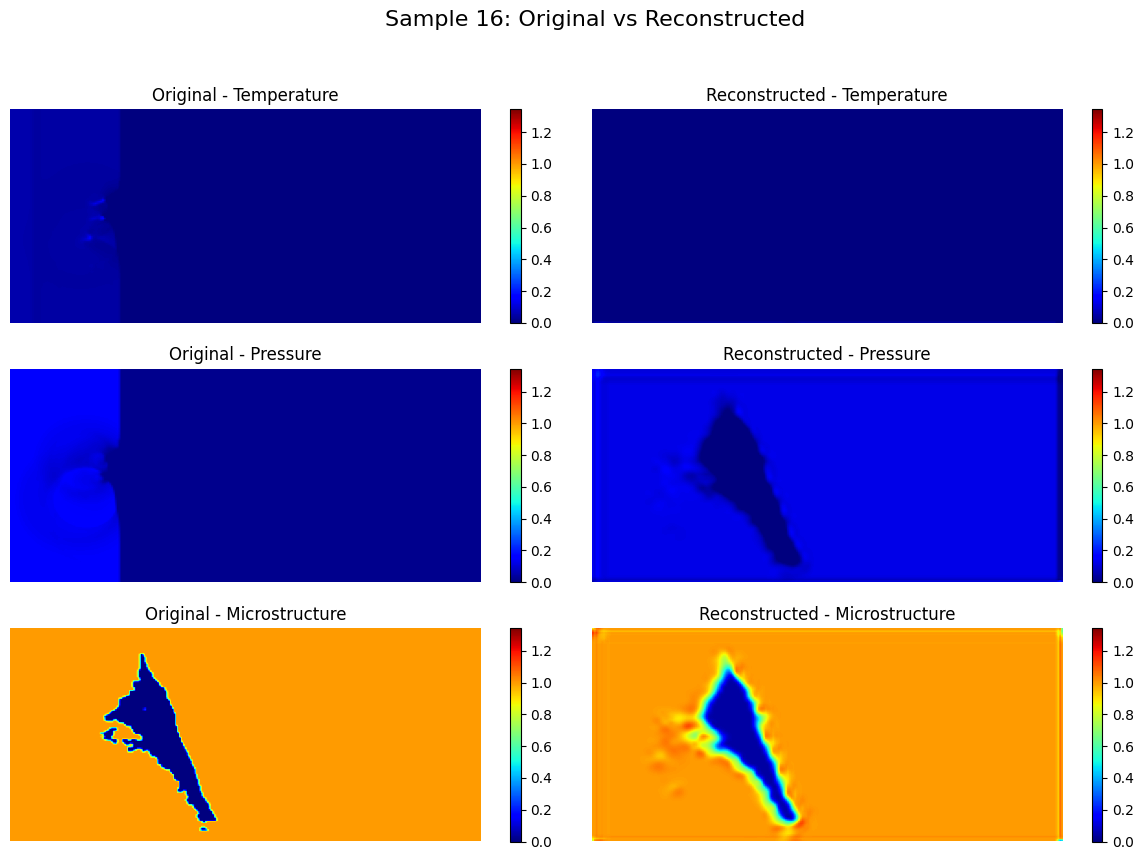

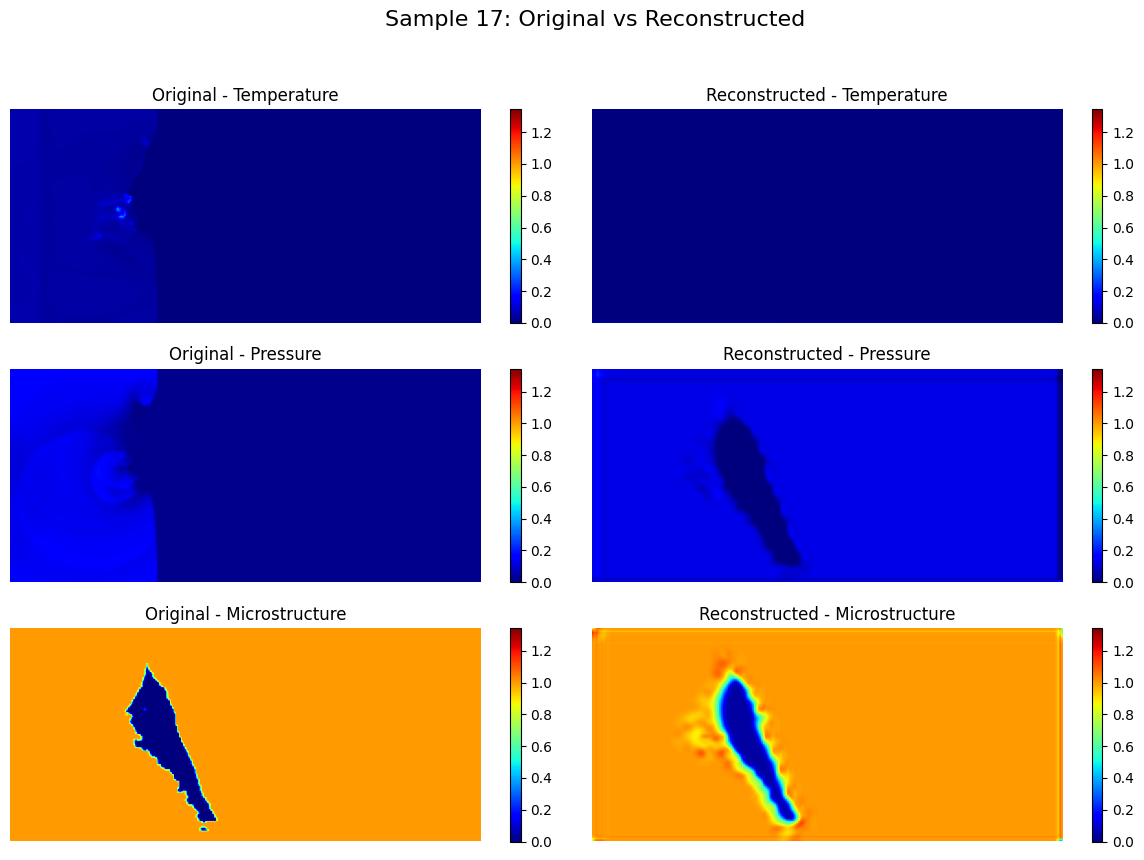

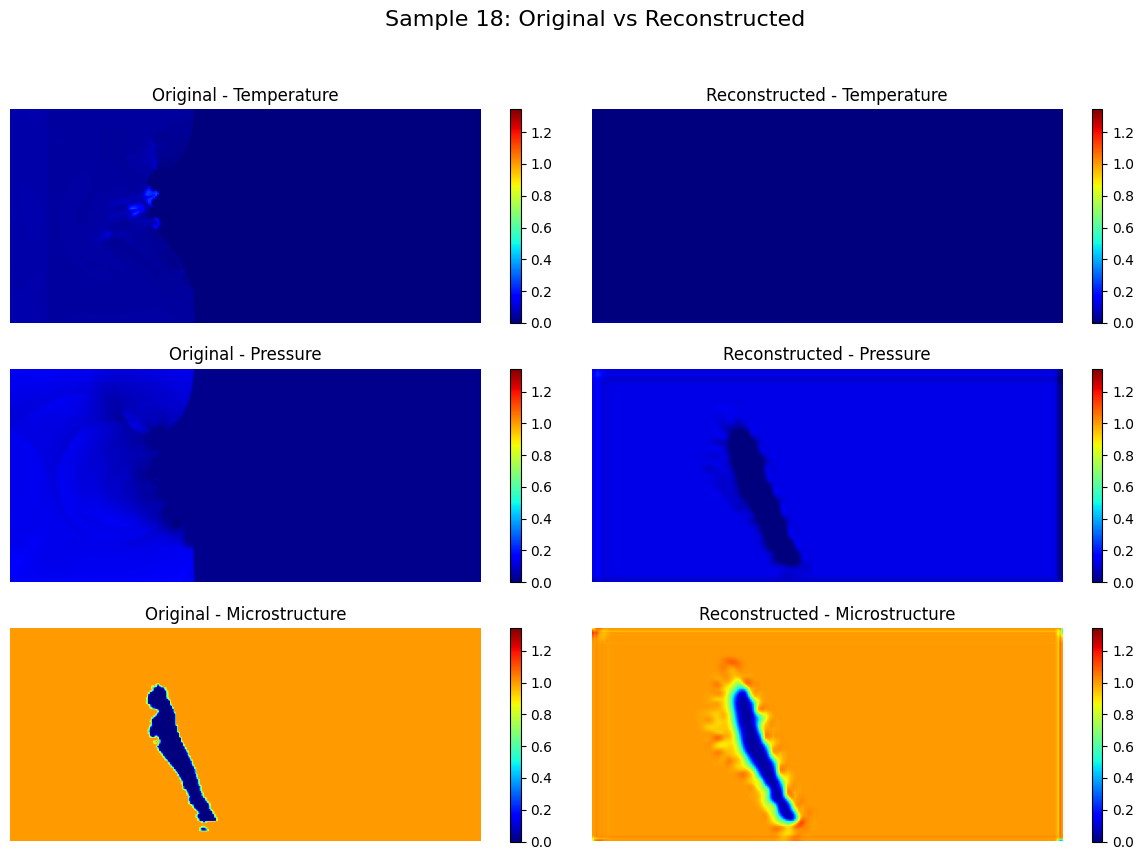

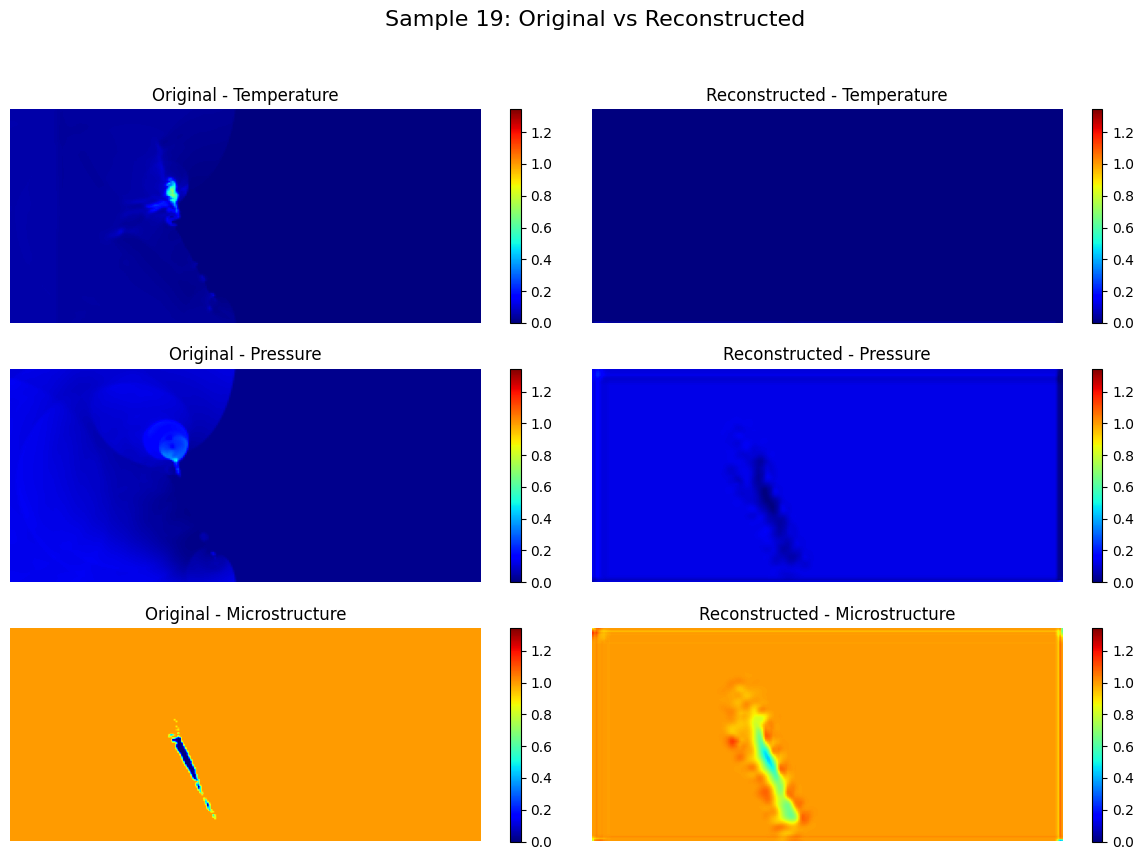

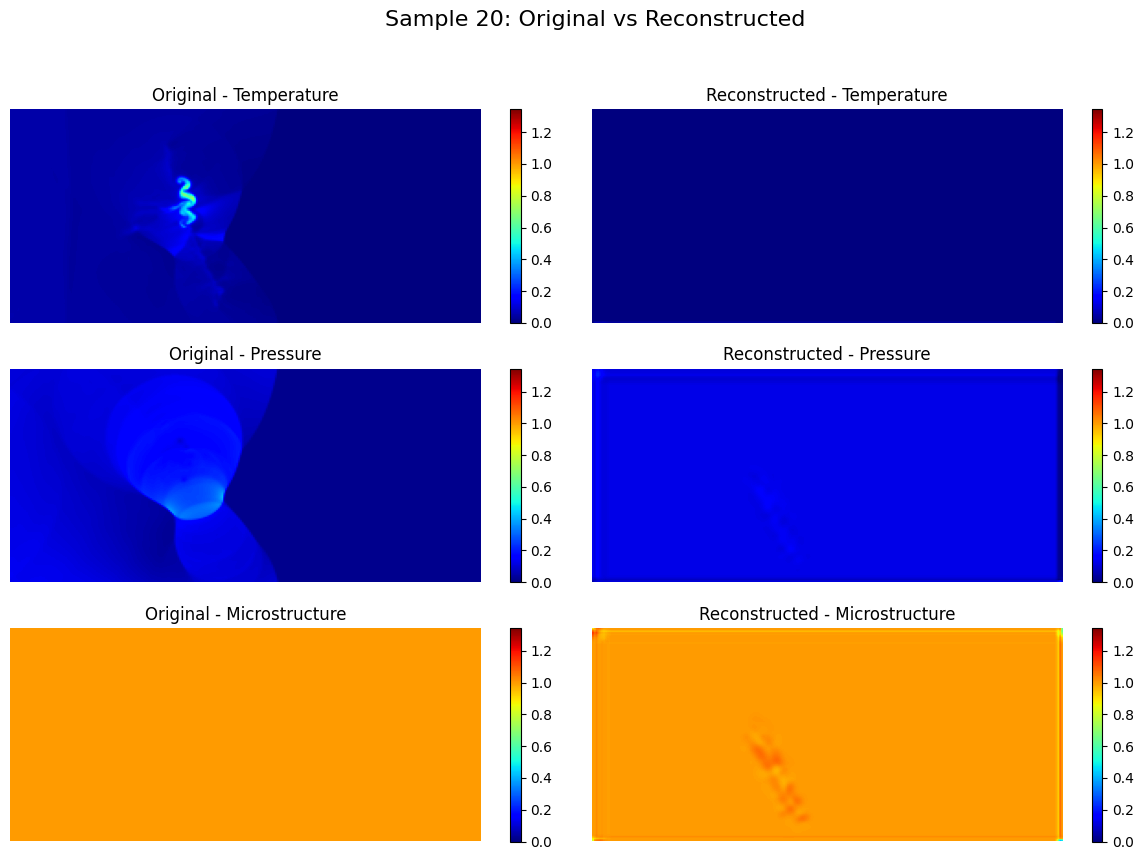

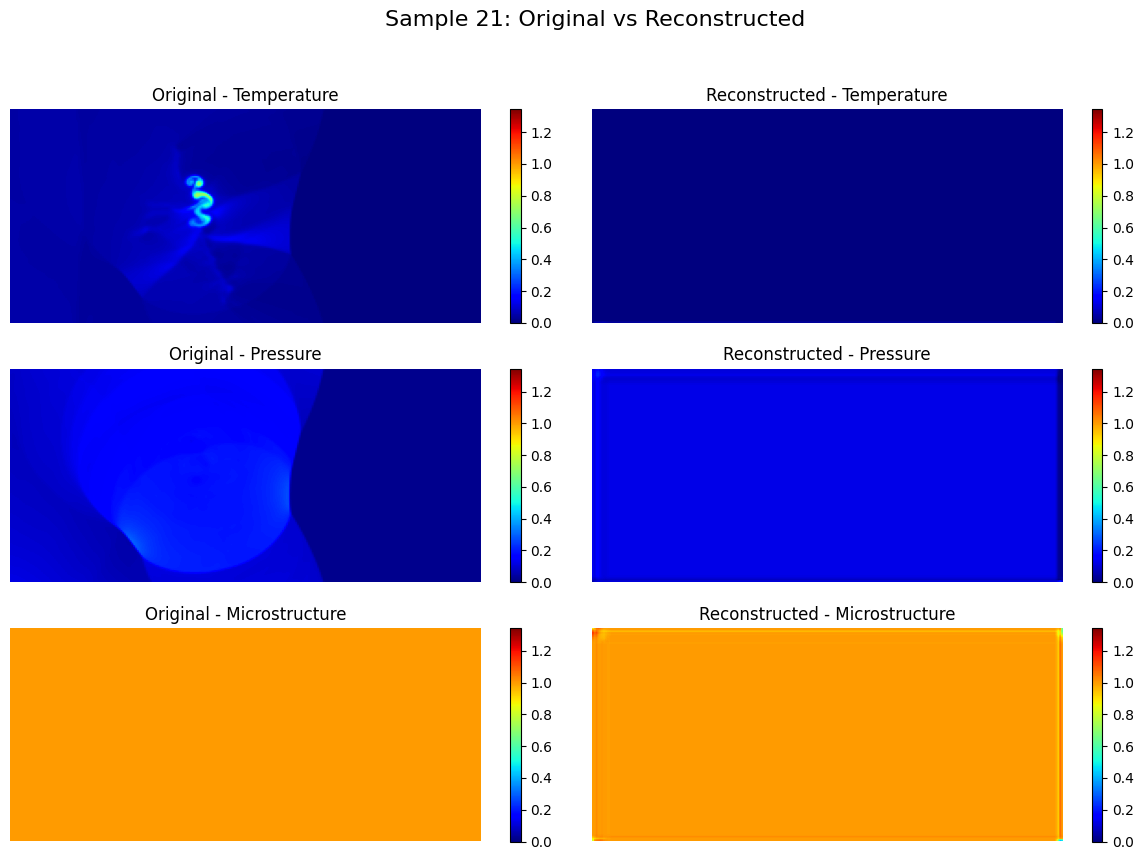

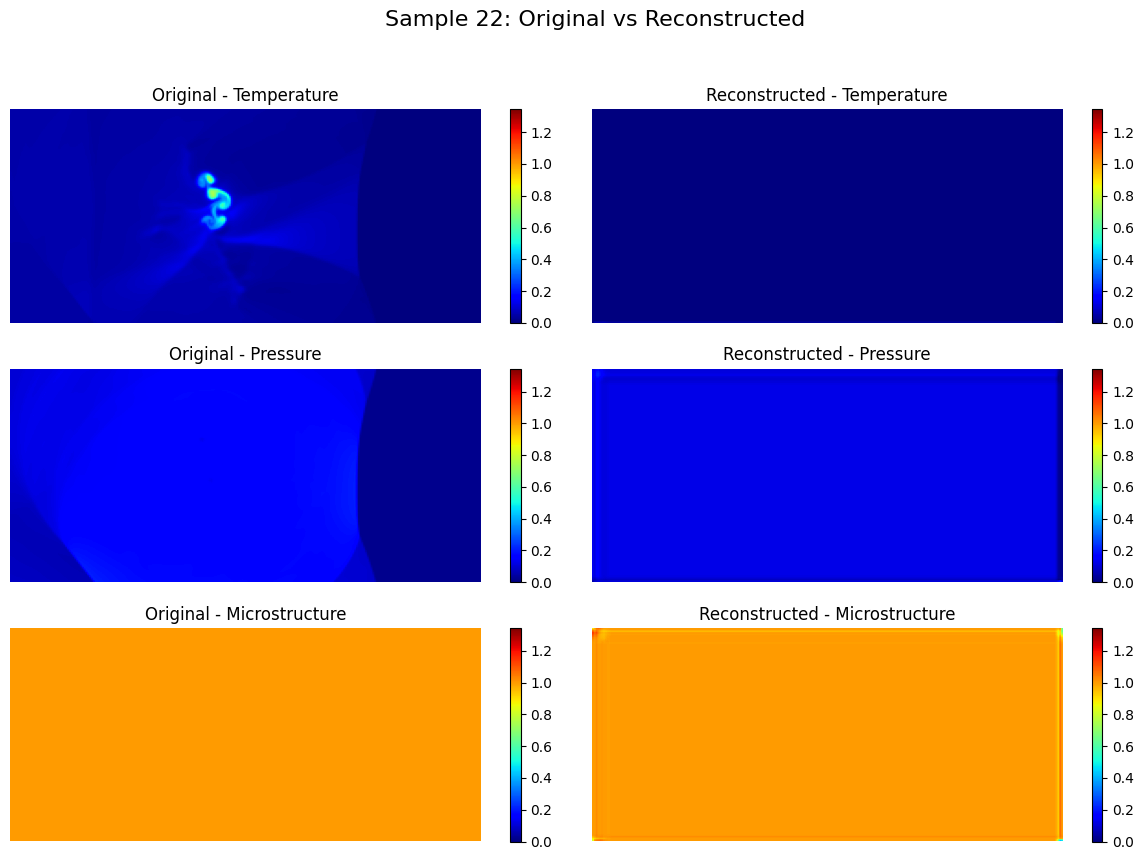

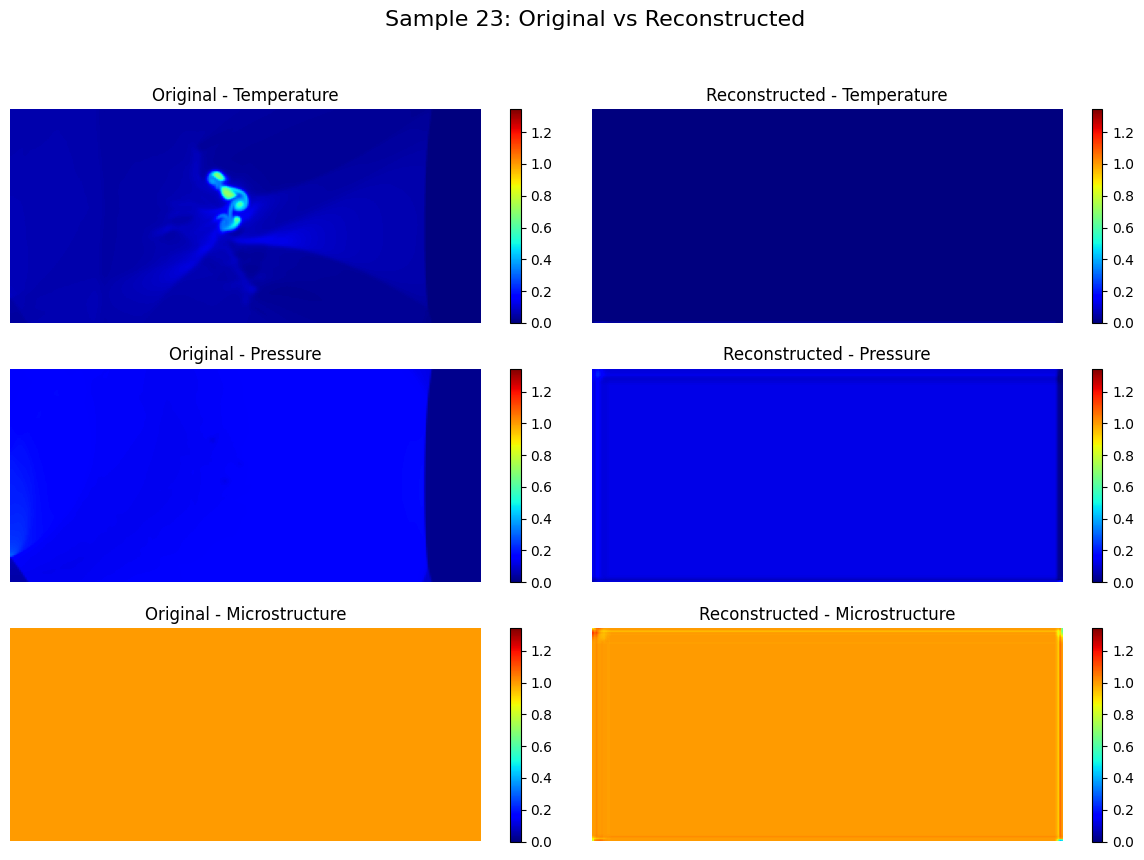

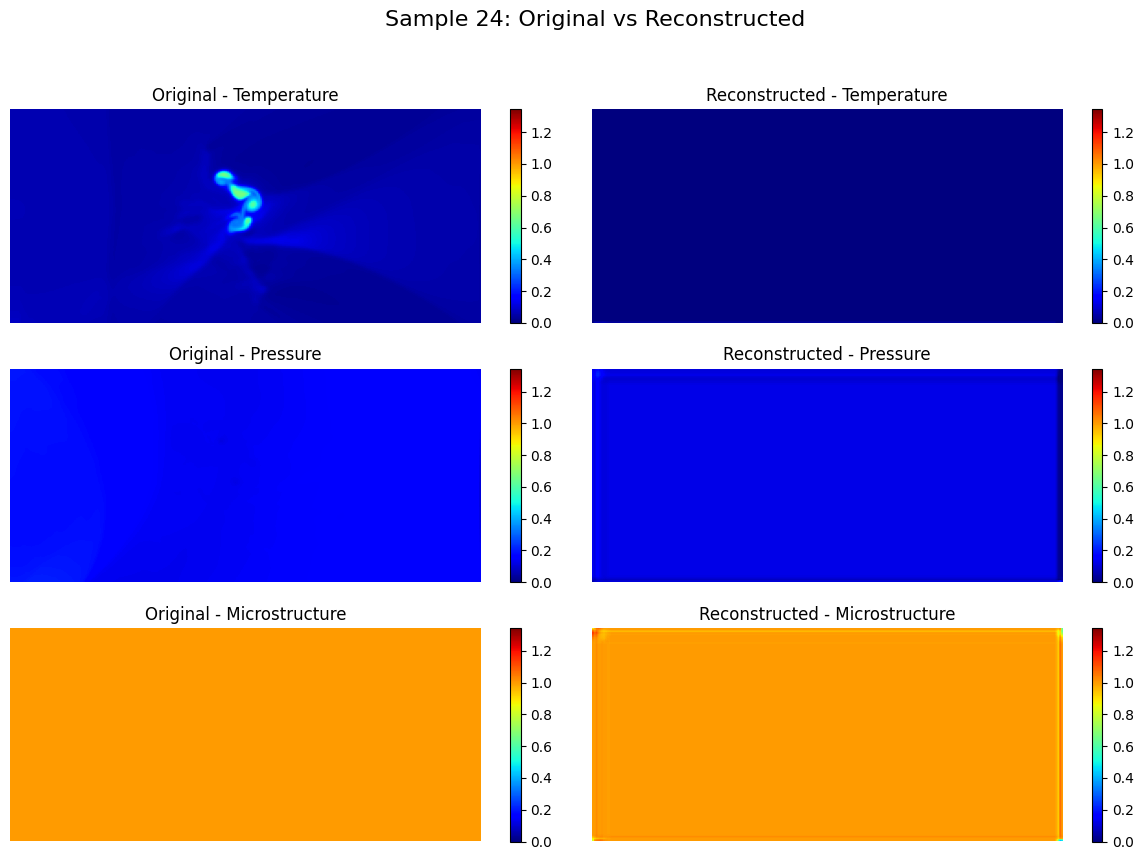

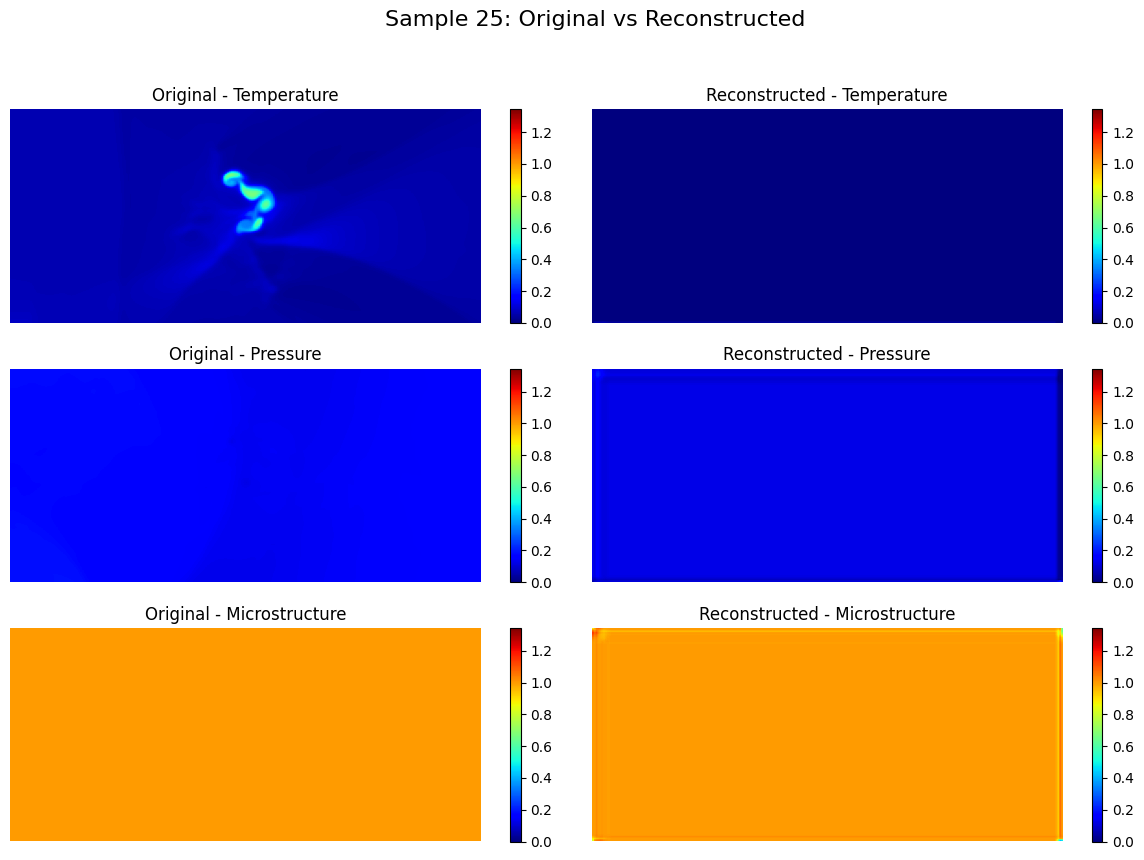

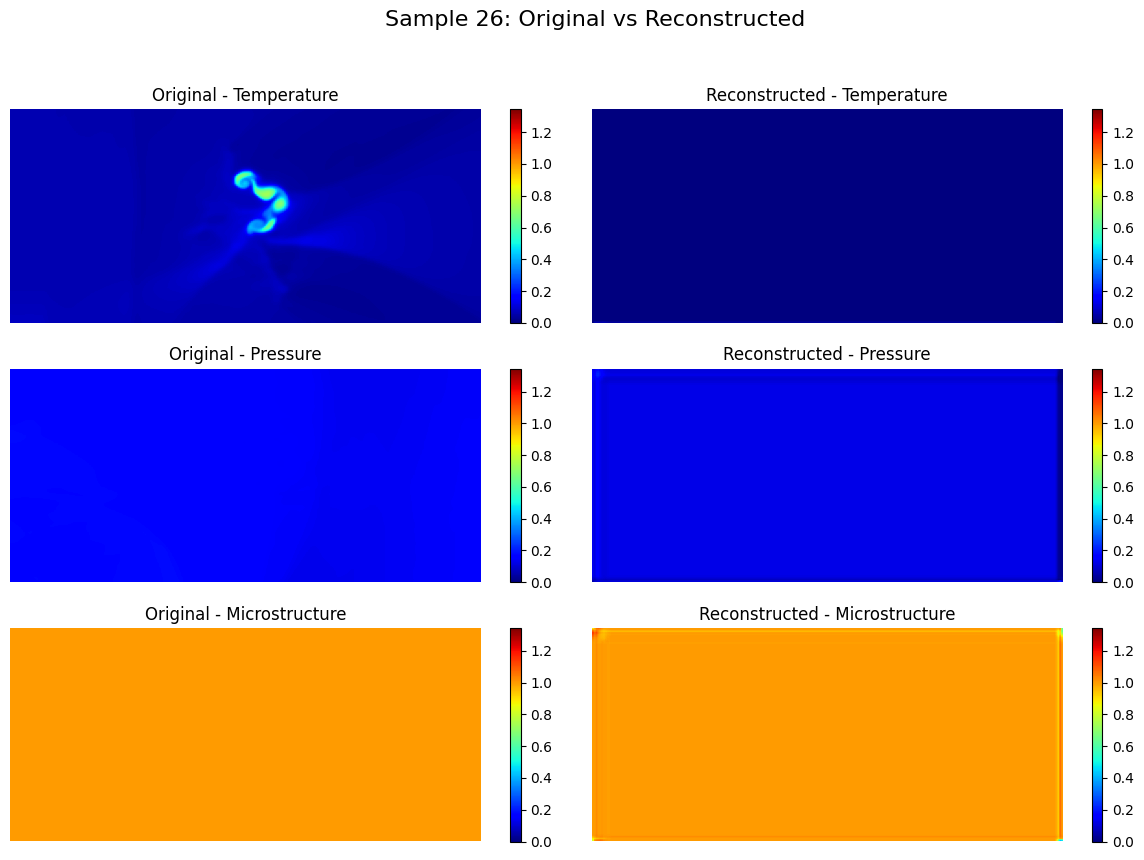

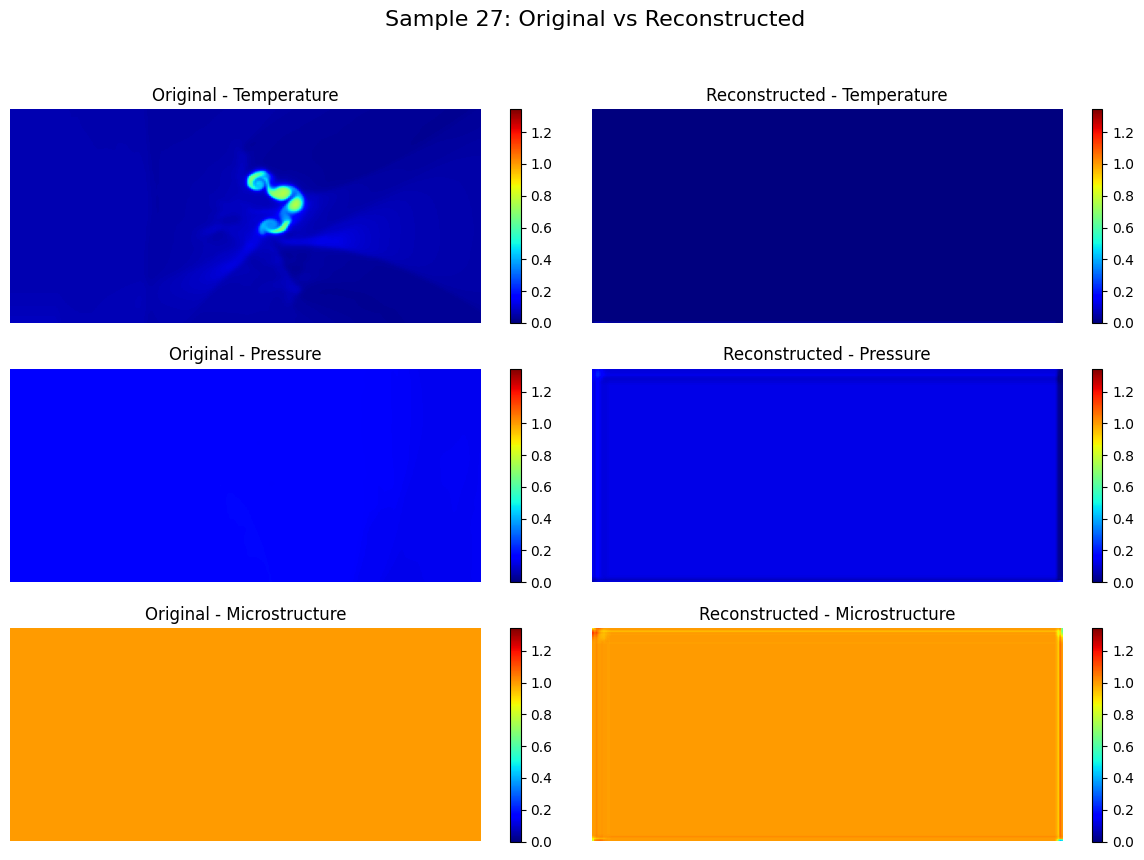

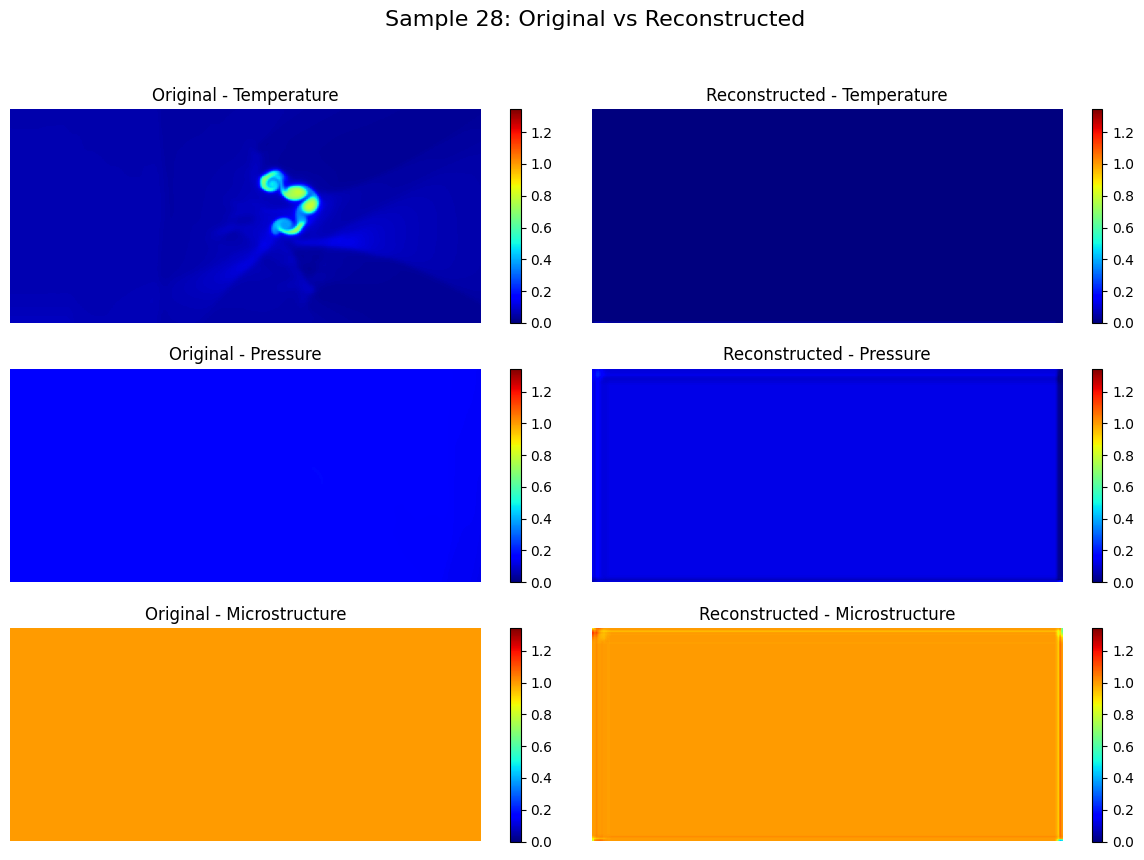

In [15]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
num_samples = min(28, single_ts_full_reconstruction_GT.shape[0])  # Display up to 5 samples or fewer if dataset is smaller

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(single_ts_full_reconstruction_GT.min(), single_ts_full_reconstruction_pred.min())
global_max = max(single_ts_full_reconstruction_GT.max(), single_ts_full_reconstruction_pred.max())

# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Original channel
        original_channel = single_ts_full_reconstruction_GT[sample_idx, channel_idx, :, :].numpy()
        # Reconstructed channel
        reconstructed_channel = single_ts_full_reconstruction_pred[sample_idx, channel_idx, :, :].numpy()

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
        
        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
    plt.show()

#### GIF - Single ts LP Pred

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

file_name = "LP_2plus1_1decoder_layers_2_4_latent_4_decoder_6_AE_3000"
plot_name = "Single ts Prediction, 2plus1_1decoder, layers 2 4, latent 4, 2 Test Samples, 3000 Epochs"

# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
# num_samples = min(28, single_ts_full_reconstruction_GT.shape[0])  # Display up to 30 samples or fewer if dataset is smaller
num_samples = 28

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(single_ts_full_reconstruction_GT.min(), single_ts_full_reconstruction_pred.min())
global_max = max(single_ts_full_reconstruction_GT.max(), single_ts_full_reconstruction_pred.max())

frames = []  # List to store frames for GIF

# Iterate over the selected samples (each sample represents a time step)
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(2, 3, figsize=(6, 4), dpi=150, constrained_layout=True)  # Reduced figsize and dpi for smaller GIF
    fig.suptitle(plot_name, fontsize=12)  # Reduced font size for title
    
    for channel_idx, channel_name in enumerate(channel_names):
        original_channel = single_ts_full_reconstruction_GT[sample_idx, channel_idx, :, :].numpy()
        reconstructed_channel = single_ts_full_reconstruction_pred[sample_idx, channel_idx, :, :].numpy()
        
        # Plot original
        ax = axes[0, channel_idx]
        ax.imshow(original_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (GT)", fontsize=10)  # Smaller title font size
        ax.axis("off")
        
        # Plot reconstructed
        ax = axes[1, channel_idx]
        ax.imshow(reconstructed_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (Pred)", fontsize=10)  # Smaller title font size
        ax.axis("off")
    
    # Convert the figure to a PIL Image and append to frames
    fig.canvas.draw()  # Draw the figure onto the canvas
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))  # Reshape to image dimensions
    frames.append(Image.fromarray(img))

    plt.close(fig)

# Check if frames are created successfully
if len(frames) == 0:
    print("Error: No frames generated!")
else:
    # Save frames as GIF
    gif_path = file_name + ".gif"
    try:
        frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0)
        print(f"GIF saved to {gif_path}")
    except Exception as e:
        print(f"Error saving GIF: {e}")


/tmp/ipykernel_174026/1198255842.py:44: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved to LP_2plus1_1decoder_layers_2_4_latent_4_decoder_6_AE_3000.gif


# Loss Plots

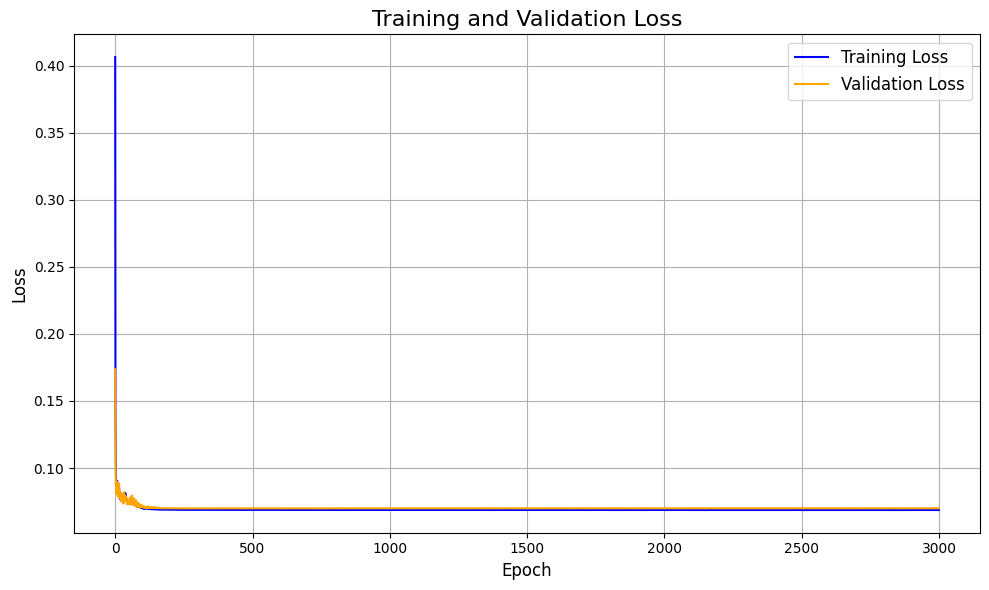

In [16]:
# Path to the JSON log file
log_file_path = "layers_2_4_latent_4_1_2_latent_2_decoder_3_6_LP_2plus1_1decoder_Nmax16_nrf8_redon500_LRstep_e3_factor8_stepsize200_nts1_3000.json"

# Load the log data
with open(log_file_path, 'r') as f:
    log_dict = json.load(f)

# Extract training and validation loss
training_loss = log_dict['training_loss_per_epoch']
validation_loss = log_dict['validation_loss_per_epoch']

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title("Training and Validation Loss", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

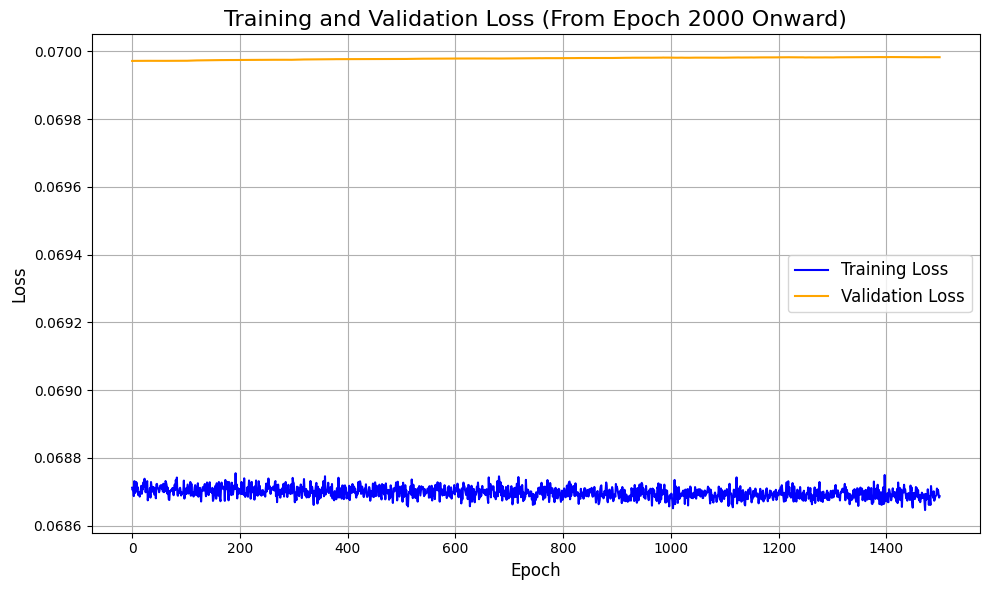

In [17]:
# Starting from the 50th epoch (index 49, since indexing starts at 0)
start_epoch = 1500

# Slice the data from the 50th epoch onward
training_loss = training_loss[start_epoch:]
validation_loss = validation_loss[start_epoch:]

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title("Training and Validation Loss (From Epoch 2000 Onward)", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

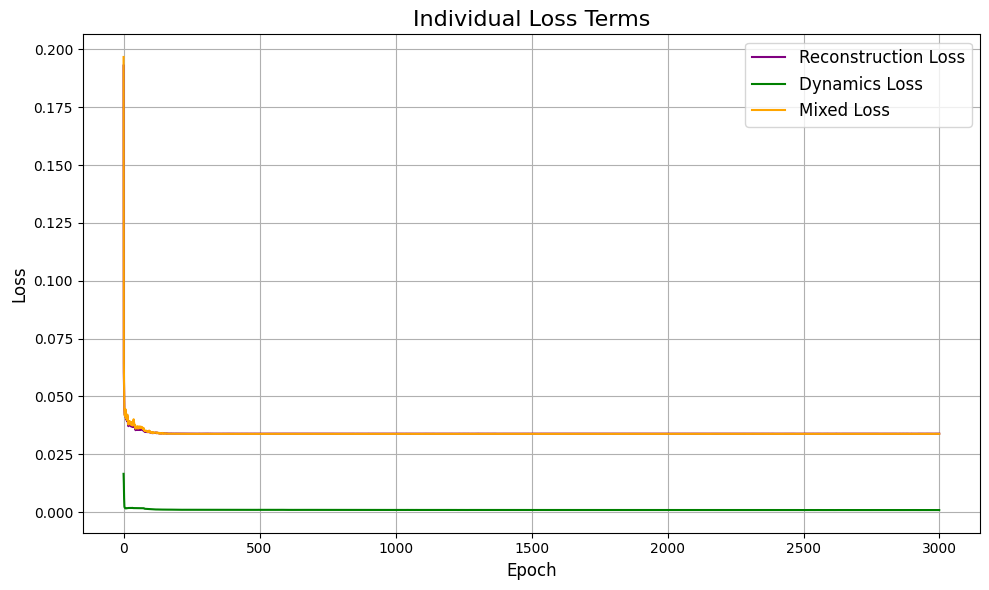

In [19]:
# Path to the JSON log file
log_file_path = "layers_2_4_latent_4_1_2_latent_2_decoder_3_6_LP_2plus1_1decoder_Nmax16_nrf8_redon500_LRstep_e3_factor8_stepsize200_nts1_3000.json"

# Load the log data
with open(log_file_path, 'r') as f:
    log_dict = json.load(f)

# Extract training and validation loss
purple_loss = log_dict['purple_loss_train']
green_loss = log_dict['green_loss_train']
orange_loss = log_dict['orange_loss_train']

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(purple_loss, label="Reconstruction Loss", color="purple")
ax.plot(green_loss, label="Dynamics Loss", color="green")
ax.plot(orange_loss, label="Mixed Loss", color="orange")

# Add titles, labels, and legend
ax.set_title("Individual Loss Terms", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

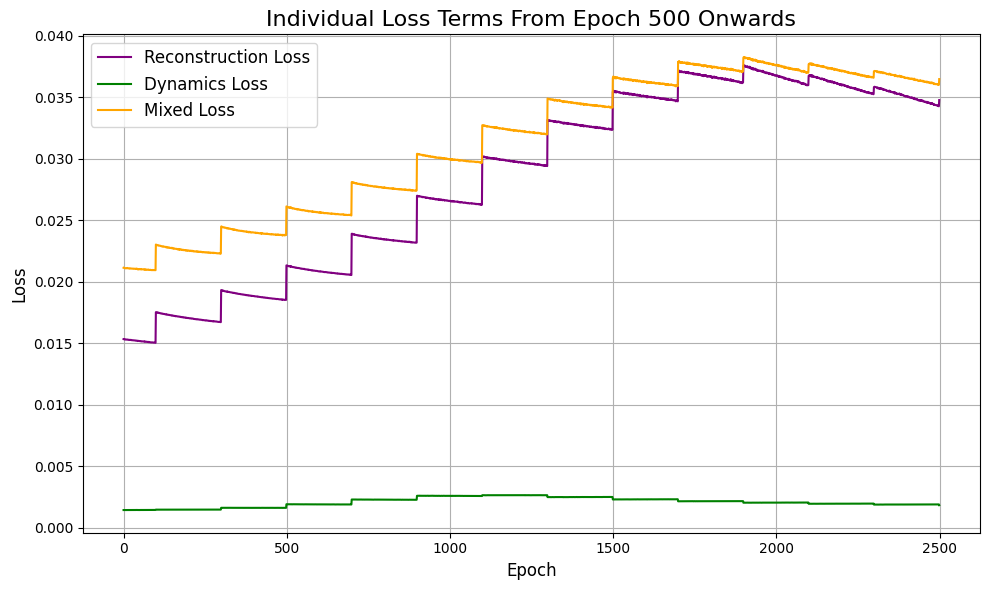

In [19]:
# Starting from the 50th epoch (index 49, since indexing starts at 0)
start_epoch = 500

# Slice the data from the 50th epoch onward
purple_loss = purple_loss[start_epoch:]
green_loss = green_loss[start_epoch:]
orange_loss = orange_loss[start_epoch:]

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(purple_loss, label="Reconstruction Loss", color="purple")
ax.plot(green_loss, label="Dynamics Loss", color="green")
ax.plot(orange_loss, label="Mixed Loss", color="orange")

# Add titles, labels, and legend
ax.set_title(f"Individual Loss Terms From Epoch {start_epoch} Onwards", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()